In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
# Import Data
# setting of directory
os.chdir("C:/Users/praga/OneDrive/My Files/Spring 2024/ML Project/Github")

# loading of data
df = pd.read_csv("diabetic_data.csv")

# other link files
admission_type = pd.read_excel('IDS_mapping.xlsx',sheet_name='admission_type')
discharge_disposition = pd.read_excel('IDS_mapping.xlsx',sheet_name='discharge_disposition')
admission_source = pd.read_excel('IDS_mapping.xlsx',sheet_name='admission_source')

In [3]:
# merging all data into collon dataframe
df = pd.merge(df, admission_type, on='admission_type_id', how='left').rename(columns={'description':'admission_type'})
df = pd.merge(df, discharge_disposition, on='discharge_disposition_id', how='left').rename(columns={'description':'discharge_disposition'})
df = pd.merge(df, admission_source, on='admission_source_id', how='left').rename(columns={'description':'admission_source'})
df.drop(['admission_type_id', 'discharge_disposition_id', 'admission_source_id'], axis = 'columns', inplace = True)

In [4]:
# view of data frame
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type,discharge_disposition,admission_source
0,2278392,8222157,Caucasian,Female,[0-10),?,1,?,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),?,3,?,?,59,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),?,2,?,?,11,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),?,2,?,?,44,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),?,1,?,?,51,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


In [6]:
# structure of data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   time_in_hospital          101766 non-null  int64 
 7   payer_code                101766 non-null  object
 8   medical_specialty         101766 non-null  object
 9   num_lab_procedures        101766 non-null  int64 
 10  num_procedures            101766 non-null  int64 
 11  num_medications           101766 non-null  int64 
 12  number_outpatient         101766 non-null  int64 
 13  number_emergency          101766 non-null  int64 
 14  numb

In [7]:
# data frame description
df.describe()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


<Axes: >

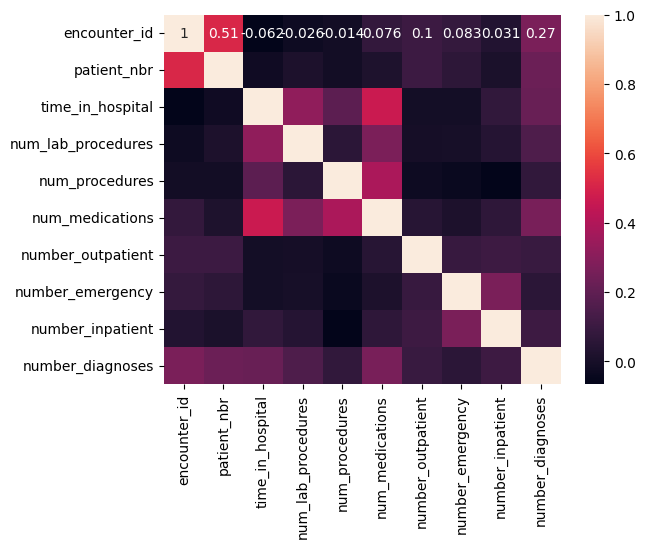

In [6]:
# checking of corelation of variables and heatmap of corelation matrix
correlation = df.corr(numeric_only=True)
sns.heatmap(correlation, annot=True)

In [7]:
# count of no of null values for each column
print(df.isnull().sum())

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide   

In [8]:
# unique values for each column
df.nunique()

encounter_id                101766
patient_nbr                  71518
race                             6
gender                           3
age                             10
weight                          10
time_in_hospital                14
payer_code                      18
medical_specialty               73
num_lab_procedures             118
num_procedures                   7
num_medications                 75
number_outpatient               39
number_emergency                33
number_inpatient                21
diag_1                         717
diag_2                         749
diag_3                         790
number_diagnoses                16
max_glu_serum                    3
A1Cresult                        3
metformin                        4
repaglinide                      4
nateglinide                      4
chlorpropamide                   4
glimepiride                      4
acetohexamide                    2
glipizide                        4
glyburide           

In [9]:
# no of categorical variables count
categorical_count = sum(df.dtypes == 'object')
categorical_count

40

In [10]:
# description and percentage distribution of data among categorical variables
for column in df.columns:
    if df[column].dtype == 'object':  # Check if the column is categorical
        print(f"Column: {column}")
        
        # Count frequencies of each category
        value_counts = df[column].value_counts()
        
        # Calculate percentage of total for each category
        percentages = (value_counts / len(df)) * 100
        
        # Combine value counts and percentages into a single DataFrame
        summary_df = pd.DataFrame({'Value Counts': value_counts, '% of Total': percentages})
        
        print(summary_df)
        print("=" * 50)  # Separator for readability

Column: race
                 Value Counts  % of Total
race                                     
Caucasian               76099   74.778413
AfricanAmerican         19210   18.876639
?                        2273    2.233555
Hispanic                 2037    2.001651
Other                    1506    1.479866
Asian                     641    0.629876
Column: gender
                 Value Counts  % of Total
gender                                   
Female                  54708   53.758623
Male                    47055   46.238429
Unknown/Invalid             3    0.002948
Column: age
          Value Counts  % of Total
age                               
[70-80)          26068   25.615628
[60-70)          22483   22.092840
[50-60)          17256   16.956547
[80-90)          17197   16.898571
[40-50)           9685    9.516931
[30-40)           3775    3.709490
[90-100)          2793    2.744532
[20-30)           1657    1.628245
[10-20)            691    0.679009
[0-10)             161    0.1

              Value Counts  % of Total
troglitazone                          
No                  101763   99.997052
Steady                   3    0.002948
Column: tolazamide
            Value Counts  % of Total
tolazamide                          
No                101727   99.961677
Steady                38    0.037341
Up                     1    0.000983
Column: examide
         Value Counts  % of Total
examide                          
No             101766       100.0
Column: citoglipton
             Value Counts  % of Total
citoglipton                          
No                 101766       100.0
Column: insulin
         Value Counts  % of Total
insulin                          
No              47383   46.560737
Steady          30849   30.313661
Down            12218   12.005974
Up              11316   11.119627
Column: glyburide-metformin
                     Value Counts  % of Total
glyburide-metformin                          
No                         101060   99.306252
St

Column: race
              race  mean_target
0                ?     0.082710
1  AfricanAmerican     0.112181
2            Asian     0.101404
3        Caucasian     0.112906
4         Hispanic     0.104075
5            Other     0.096282


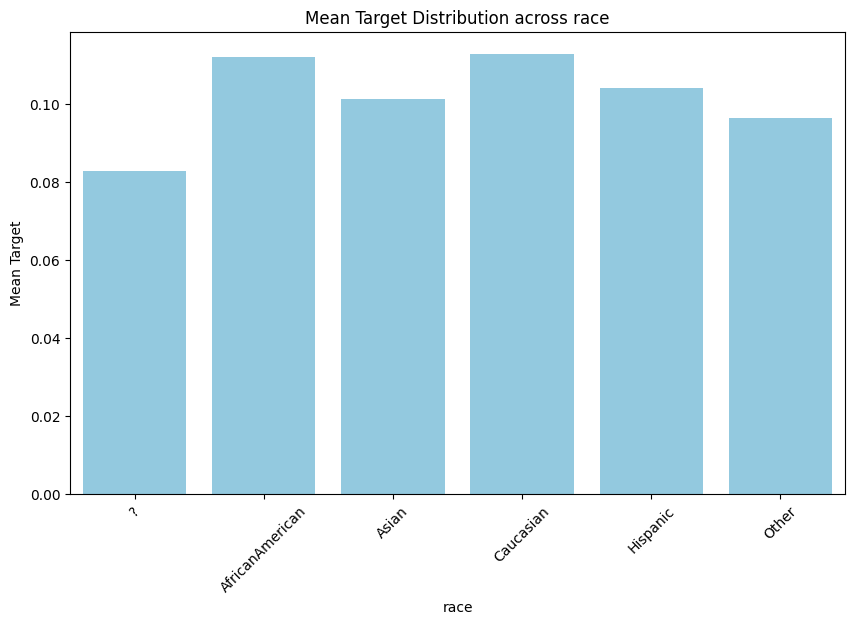

Column: gender
            gender  mean_target
0           Female     0.112452
1             Male     0.110615
2  Unknown/Invalid     0.000000


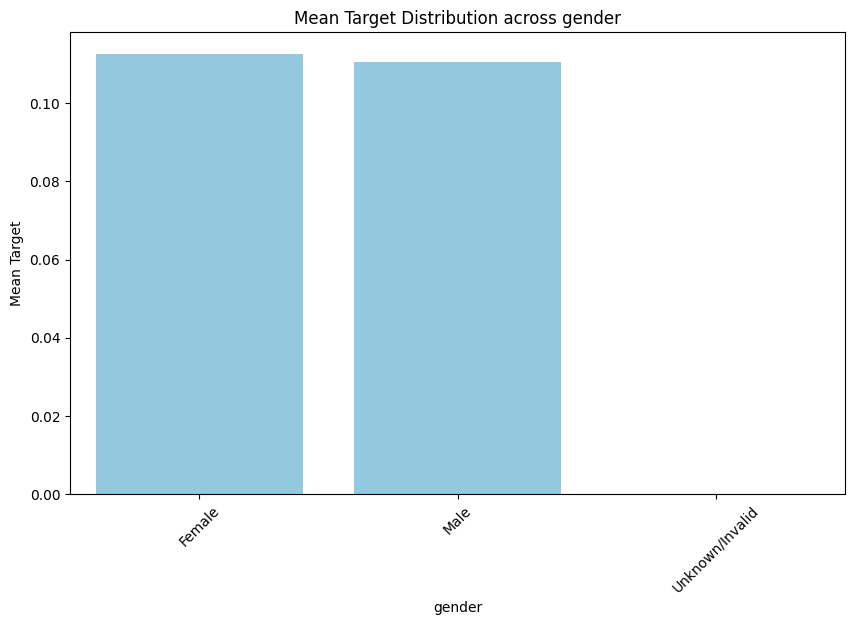

Column: age
        age  mean_target
0    [0-10)     0.018634
1   [10-20)     0.057887
2   [20-30)     0.142426
3   [30-40)     0.112318
4   [40-50)     0.106040
5   [50-60)     0.096662
6   [60-70)     0.111284
7   [70-80)     0.117731
8   [80-90)     0.120835
9  [90-100)     0.110992


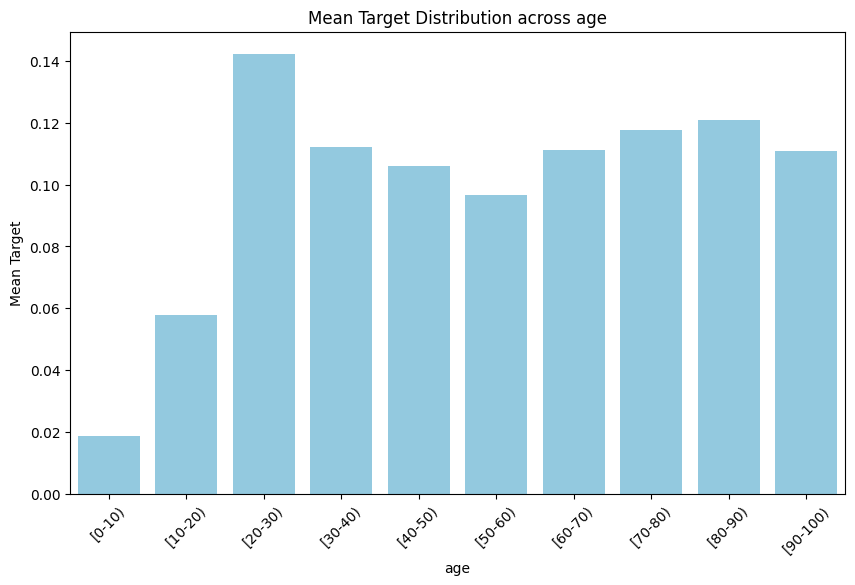

Column: weight
      weight  mean_target
0       >200     0.000000
1          ?     0.111597
2     [0-25)     0.166667
3  [100-125)     0.107200
4  [125-150)     0.082759
5  [150-175)     0.085714
6  [175-200)     0.090909
7    [25-50)     0.082474
8    [50-75)     0.117057
9   [75-100)     0.114521


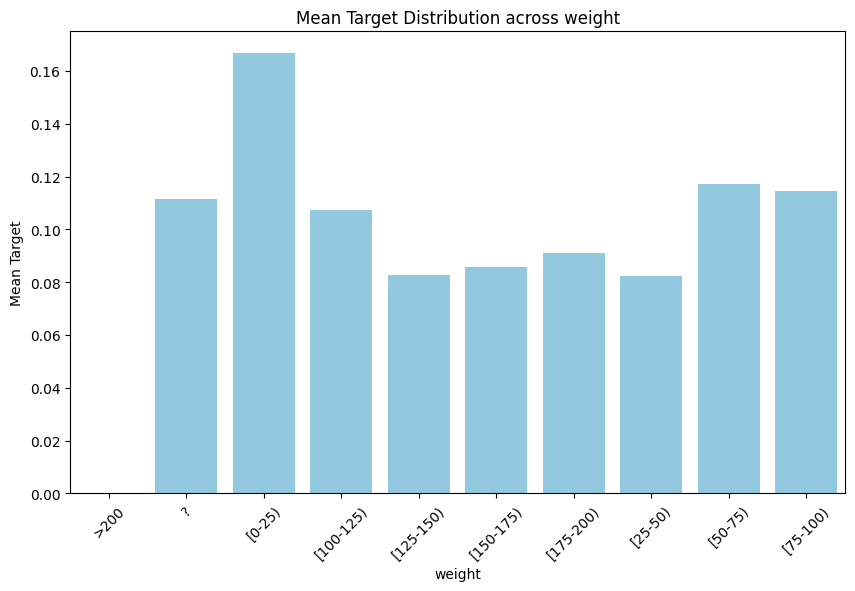

Column: payer_code
   payer_code  mean_target
0           ?     0.114939
1          BC     0.091515
2          CH     0.089041
3          CM     0.102220
4          CP     0.084485
5          DM     0.116576
6          FR     0.000000
7          HM     0.102646
8          MC     0.117451
9          MD     0.117780
10         MP     0.113924
11         OG     0.131655
12         OT     0.073684
13         PO     0.074324
14         SI     0.127273
15         SP     0.101857
16         UN     0.092729
17         WC     0.037037


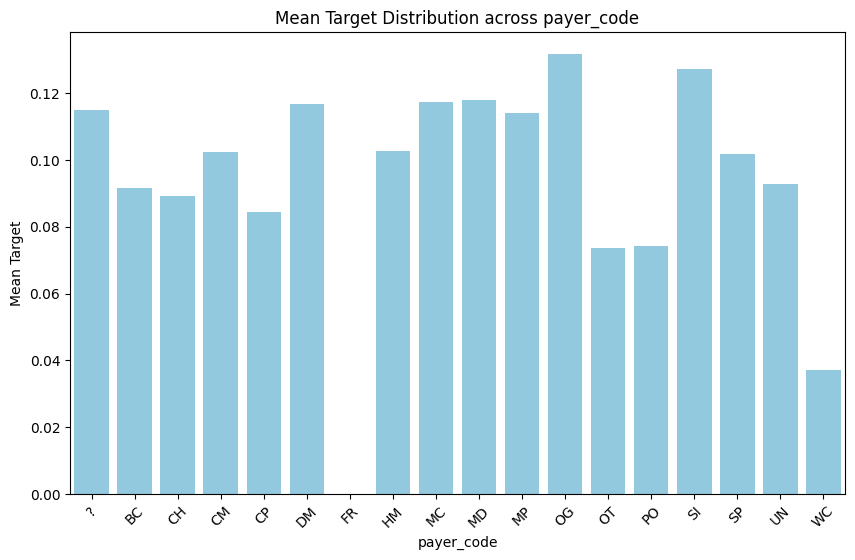

Column: medical_specialty
                   medical_specialty  mean_target
0                                  ?     0.115738
1               AllergyandImmunology     0.428571
2                     Anesthesiology     0.083333
3           Anesthesiology-Pediatric     0.052632
4                         Cardiology     0.079410
..                               ...          ...
68  Surgery-PlasticwithinHeadandNeck     0.000000
69                  Surgery-Thoracic     0.100917
70                  Surgery-Vascular     0.138837
71                 SurgicalSpecialty     0.060606
72                           Urology     0.099270

[73 rows x 2 columns]


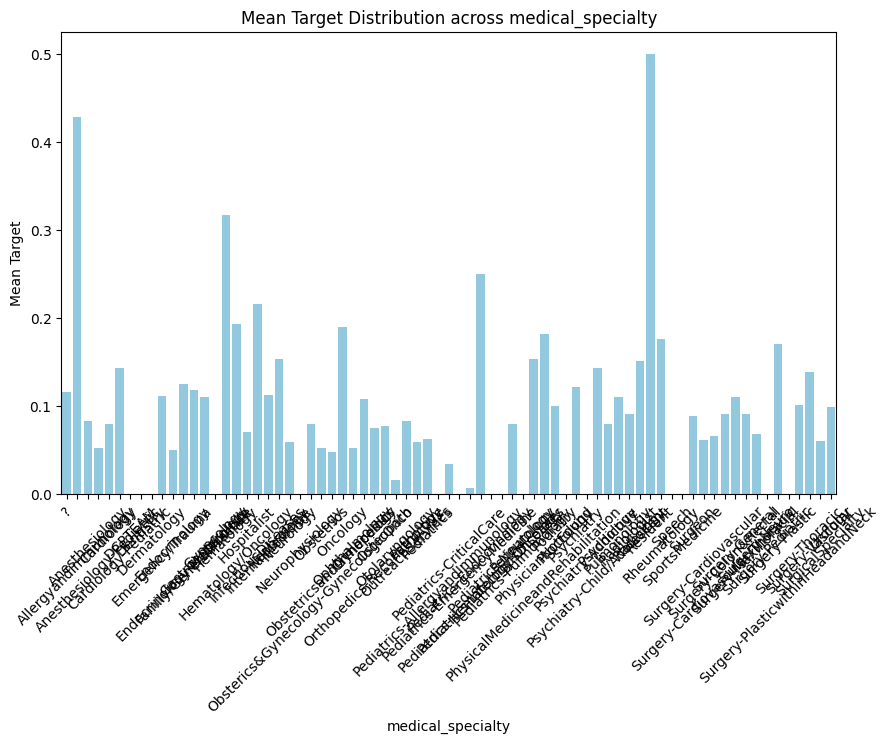

Column: diag_1
    diag_1  mean_target
0       10     0.000000
1       11     0.000000
2      110     0.000000
3      112     0.191781
4      114     0.000000
..     ...          ...
712    V63     0.125000
713    V66     0.000000
714    V67     0.000000
715    V70     0.000000
716    V71     0.000000

[717 rows x 2 columns]


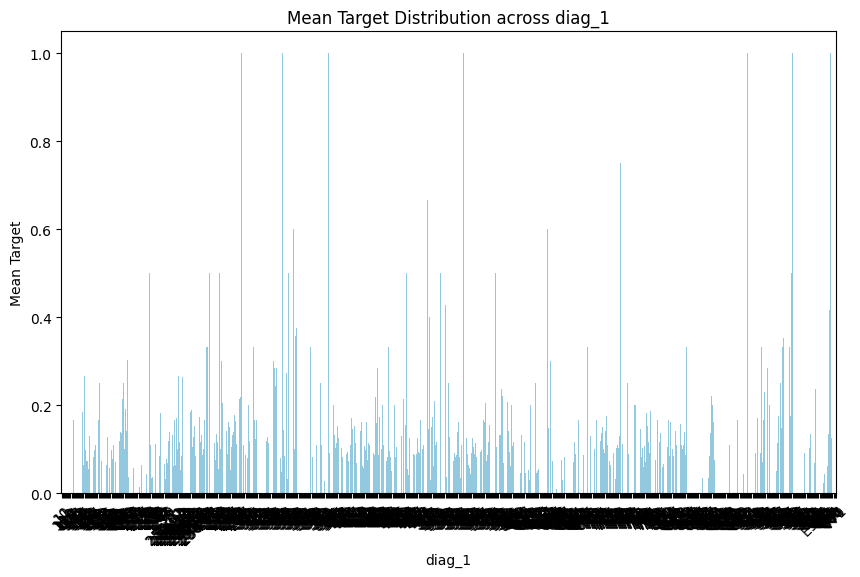

Column: diag_2
    diag_2  mean_target
0       11     0.333333
1      110     0.250000
2      111     0.000000
3      112     0.139303
4      114     1.000000
..     ...          ...
744    V69     0.000000
745    V70     0.000000
746    V72     0.000000
747    V85     0.130178
748    V86     0.000000

[749 rows x 2 columns]


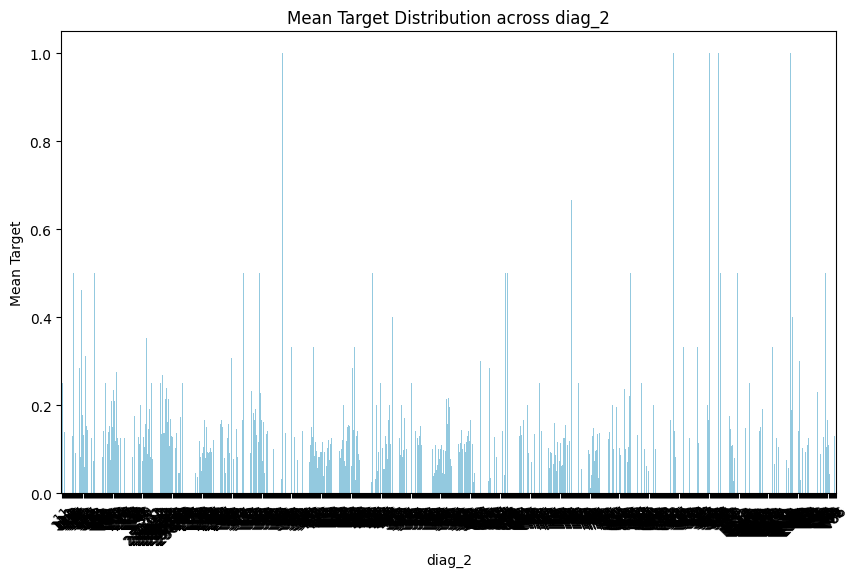

Column: diag_3
    diag_3  mean_target
0       11     0.500000
1      110     0.100000
2      111     1.000000
3      112     0.106796
4      115     0.000000
..     ...          ...
785    V66     0.055556
786    V70     0.000000
787    V72     0.125000
788    V85     0.093750
789    V86     0.000000

[790 rows x 2 columns]


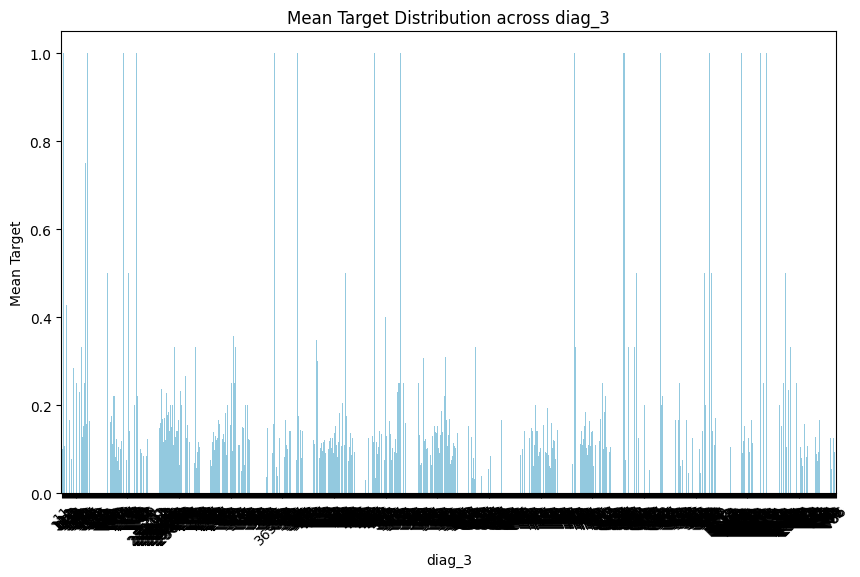

Column: max_glu_serum
  max_glu_serum  mean_target
0          >200     0.124579
1          >300     0.143196
2          Norm     0.113593


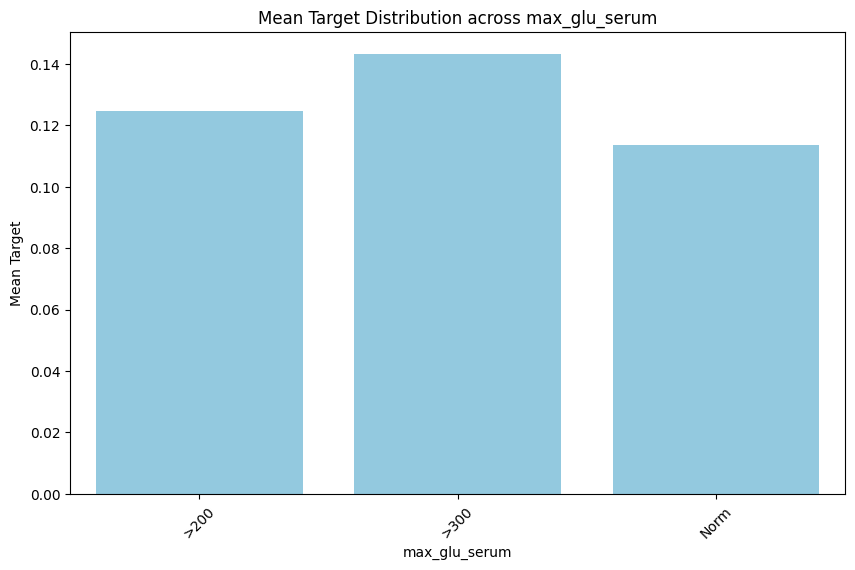

Column: A1Cresult
  A1Cresult  mean_target
0        >7     0.100472
1        >8     0.098710
2      Norm     0.096593


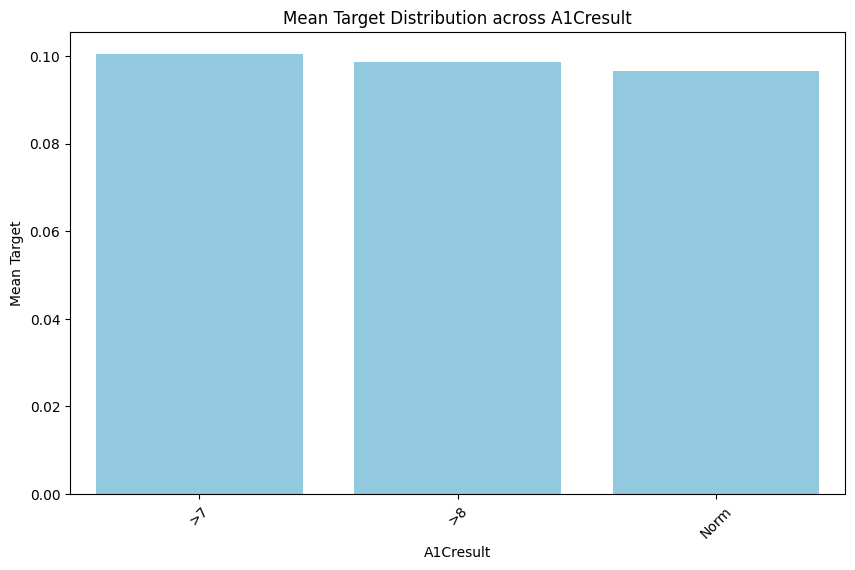

Column: metformin
  metformin  mean_target
0      Down     0.120000
1        No     0.115165
2    Steady     0.097133
3        Up     0.082474


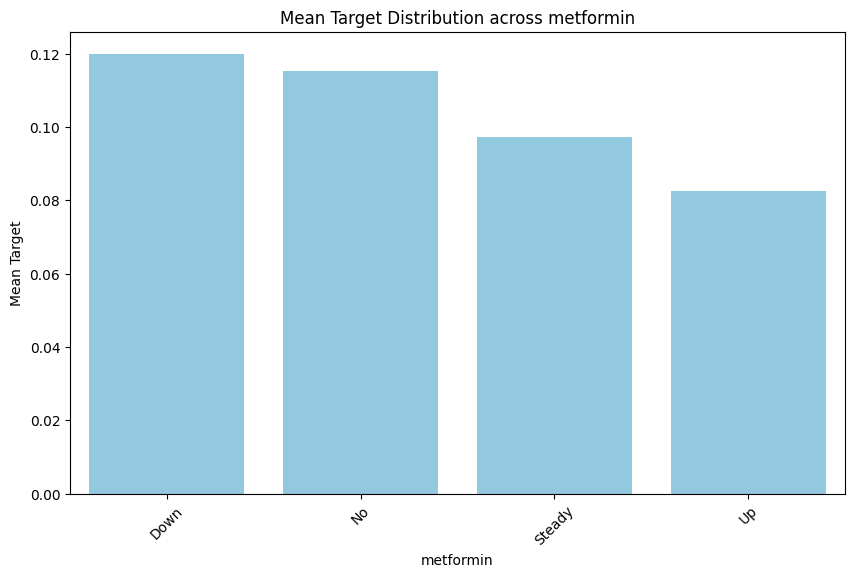

Column: repaglinide
  repaglinide  mean_target
0        Down     0.066667
1          No     0.111267
2      Steady     0.131503
3          Up     0.181818


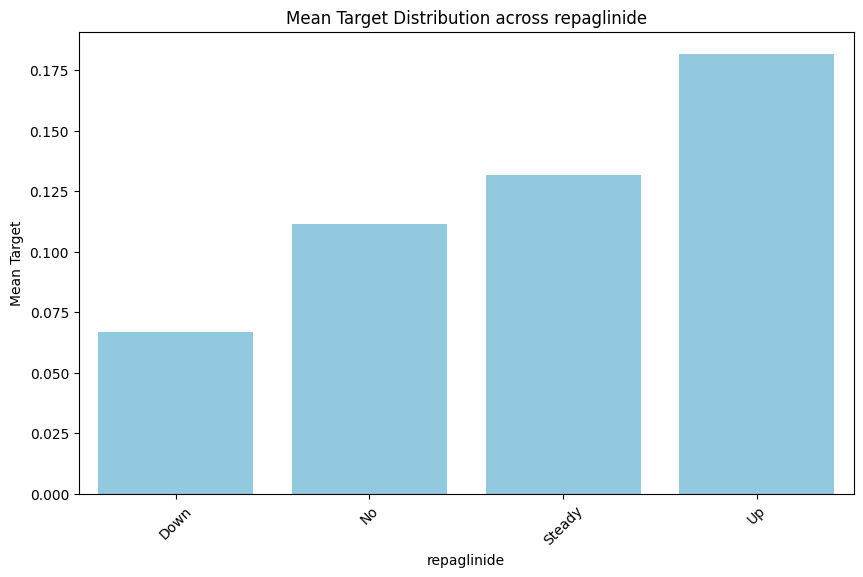

Column: nateglinide
  nateglinide  mean_target
0        Down     0.090909
1          No     0.111584
2      Steady     0.116766
3          Up     0.041667


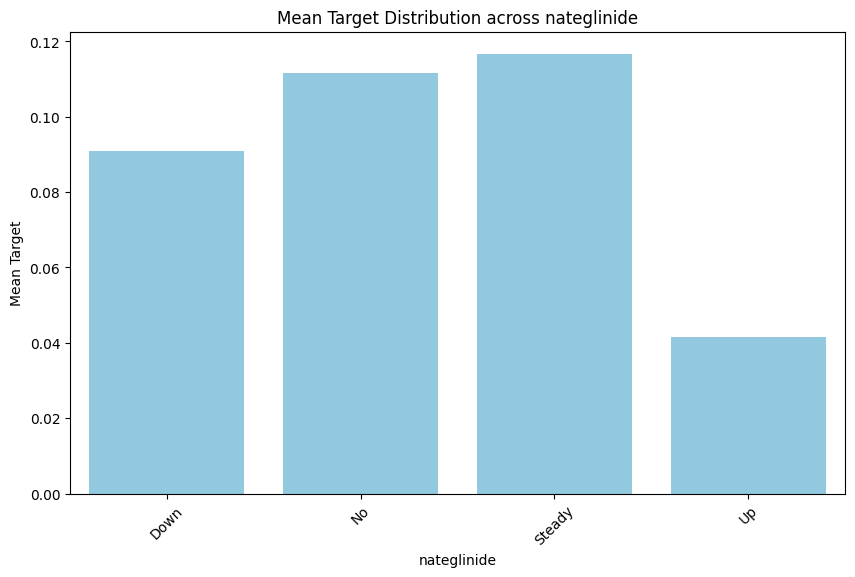

Column: chlorpropamide
  chlorpropamide  mean_target
0           Down     0.000000
1             No     0.111644
2         Steady     0.063291
3             Up     0.000000


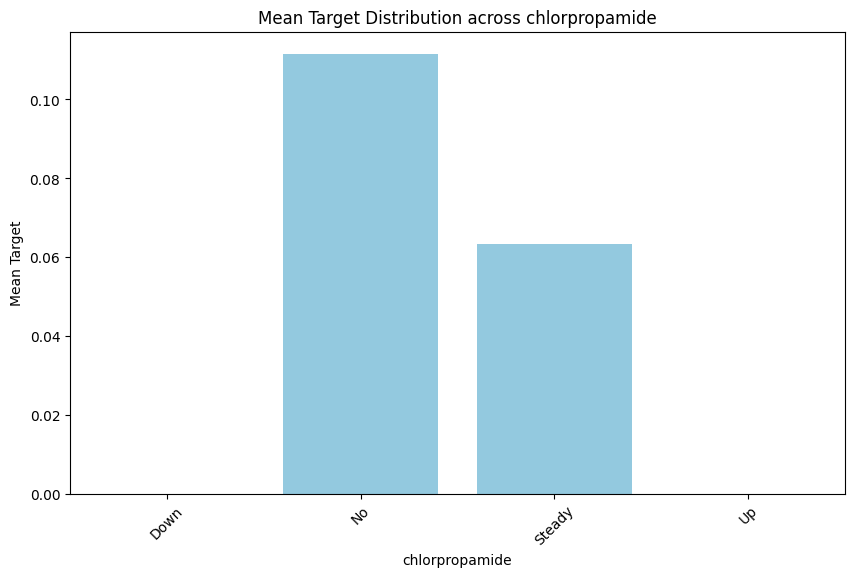

Column: glimepiride
  glimepiride  mean_target
0        Down     0.128866
1          No     0.112110
2      Steady     0.100214
3          Up     0.113150


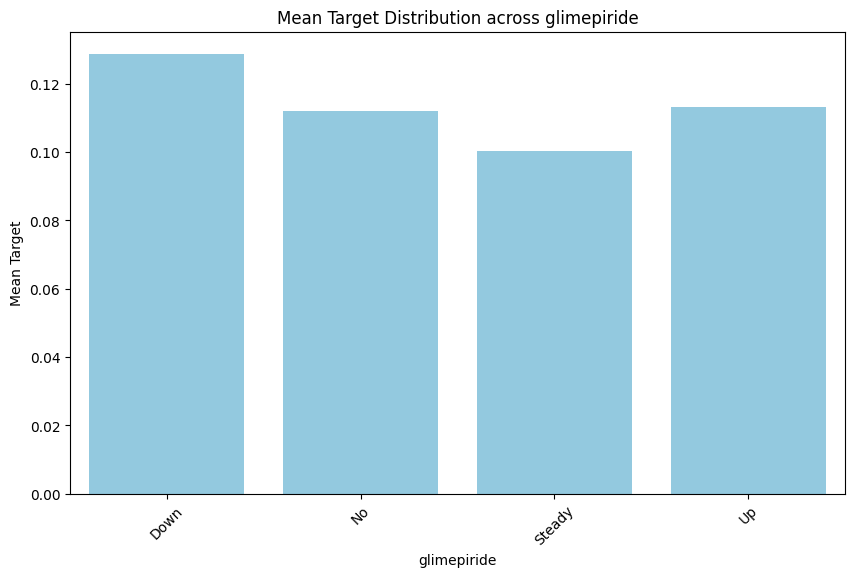

Column: acetohexamide
  acetohexamide  mean_target
0            No       0.1116
1        Steady       0.0000


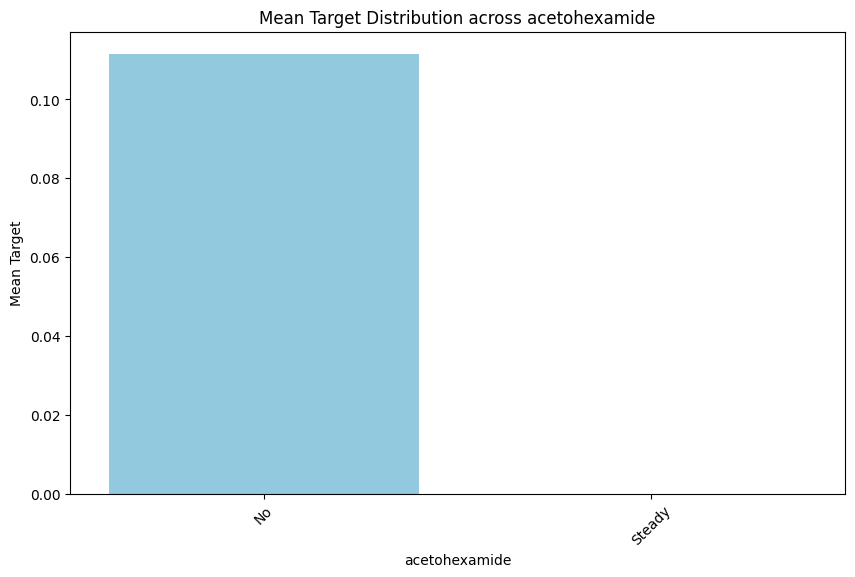

Column: glipizide
  glipizide  mean_target
0      Down     0.151786
1        No     0.111192
2    Steady     0.111659
3        Up     0.128571


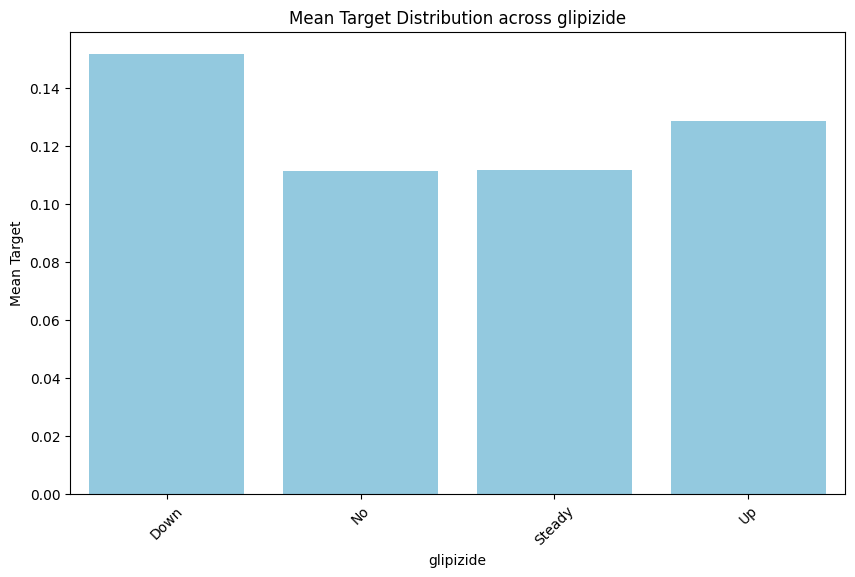

Column: glyburide
  glyburide  mean_target
0      Down     0.092199
1        No     0.112220
2    Steady     0.107289
3        Up     0.104680


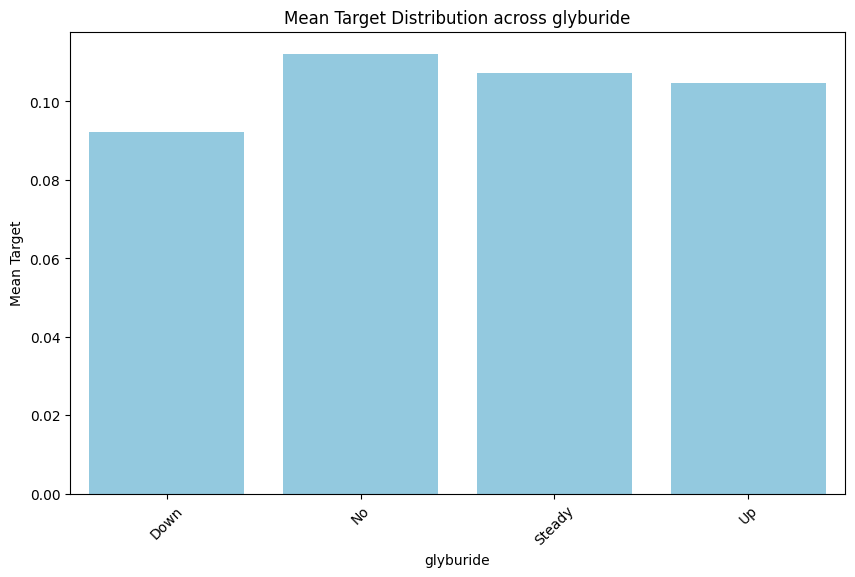

Column: tolbutamide
  tolbutamide  mean_target
0          No     0.111615
1      Steady     0.043478


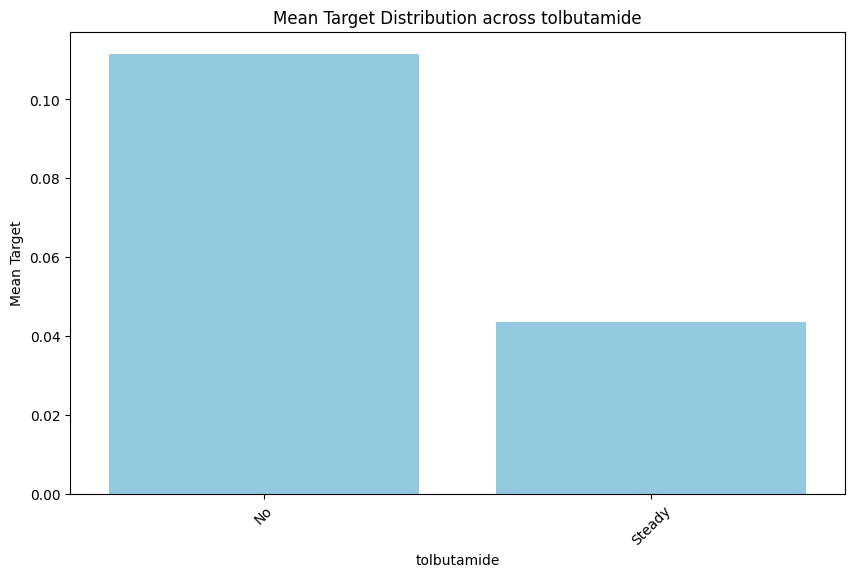

Column: pioglitazone
  pioglitazone  mean_target
0         Down     0.152542
1           No     0.112063
2       Steady     0.104214
3           Up     0.123932


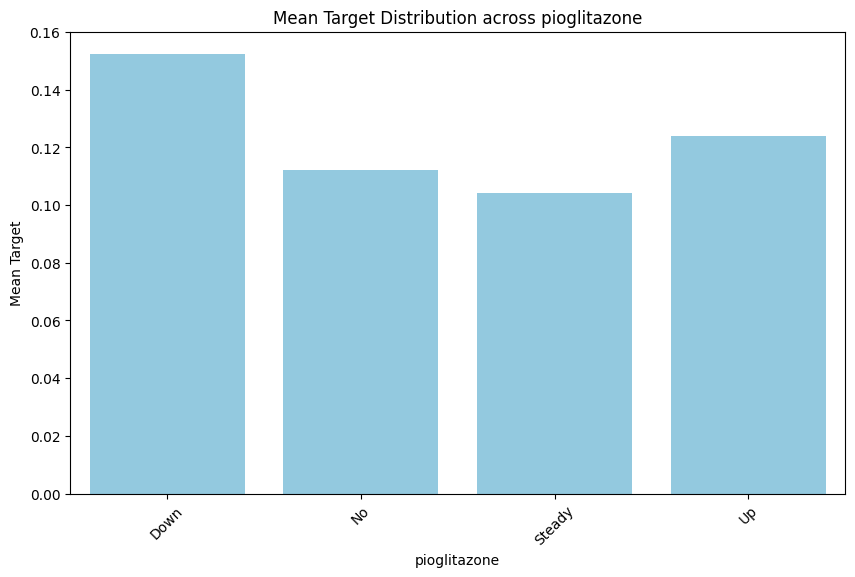

Column: rosiglitazone
  rosiglitazone  mean_target
0          Down     0.057471
1            No     0.112074
2        Steady     0.105082
3            Up     0.106742


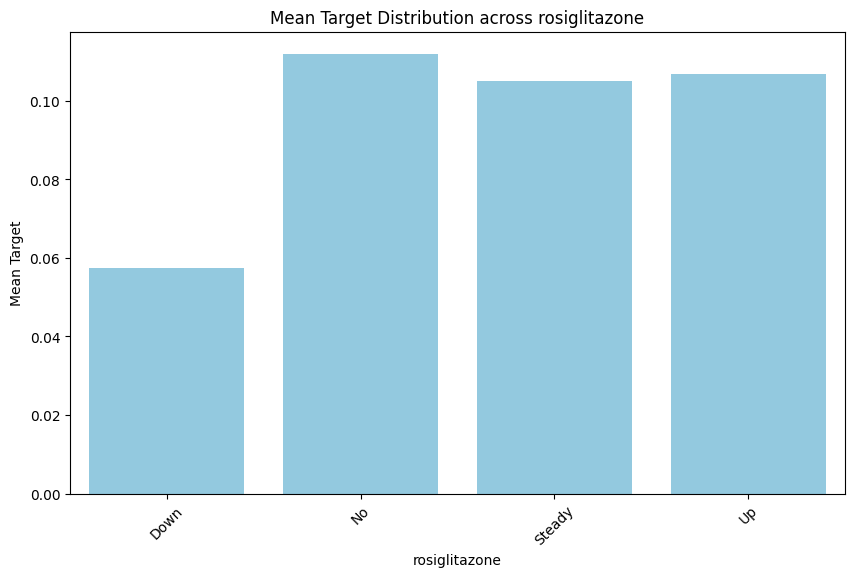

Column: acarbose
  acarbose  mean_target
0     Down     0.333333
1       No     0.111662
2   Steady     0.084746
3       Up     0.200000


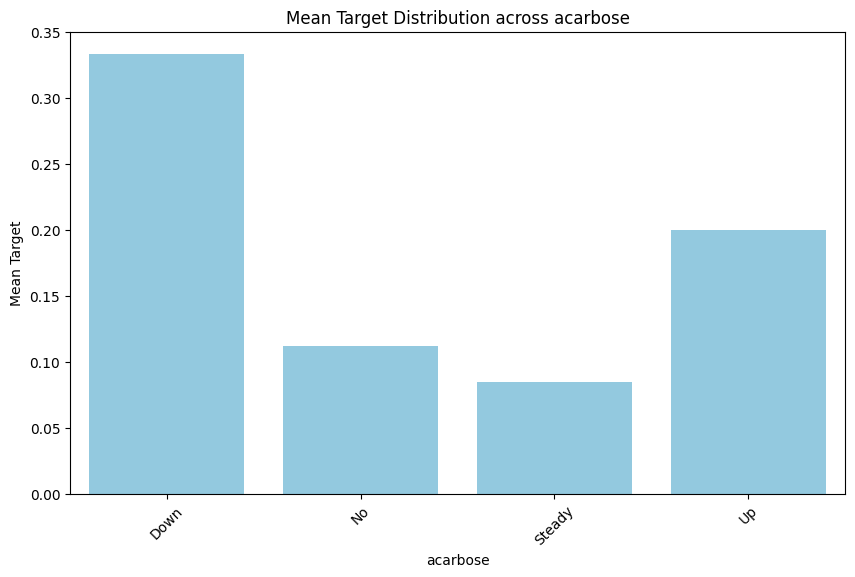

Column: miglitol
  miglitol  mean_target
0     Down     0.400000
1       No     0.111602
2   Steady     0.064516
3       Up     0.000000


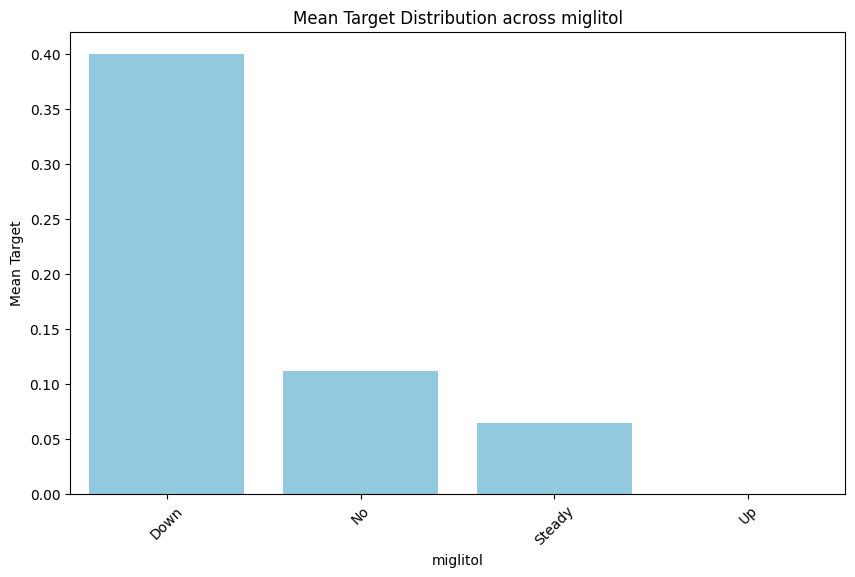

Column: troglitazone
  troglitazone  mean_target
0           No     0.111602
1       Steady     0.000000


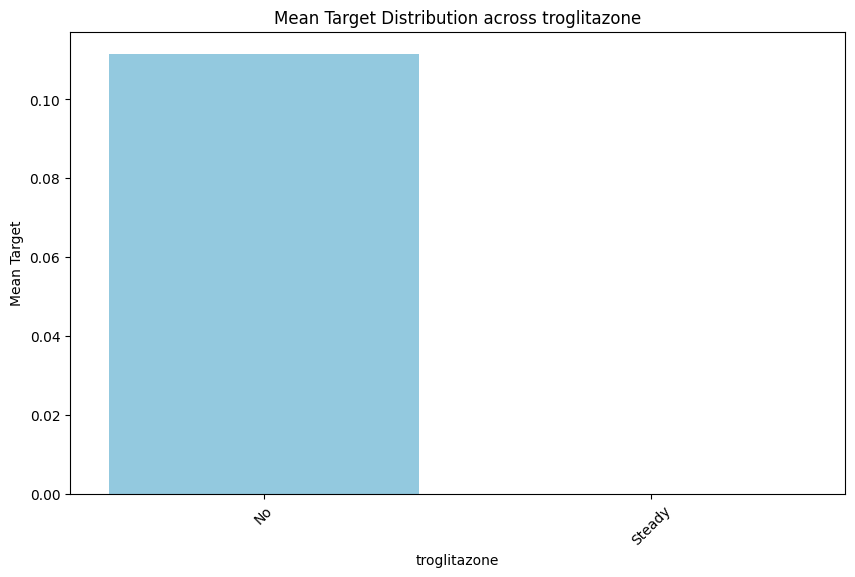

Column: tolazamide
  tolazamide  mean_target
0         No     0.111612
1     Steady     0.078947
2         Up     0.000000


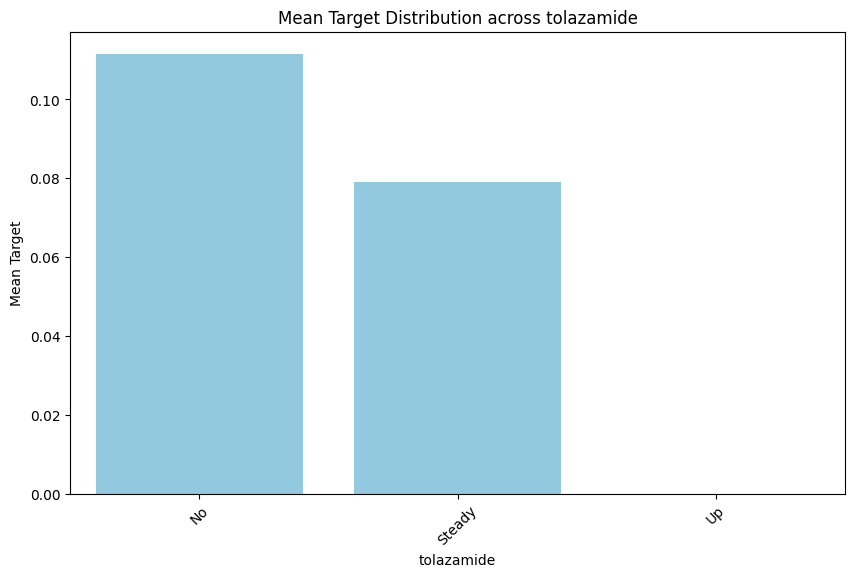

Column: examide
  examide  mean_target
0      No     0.111599


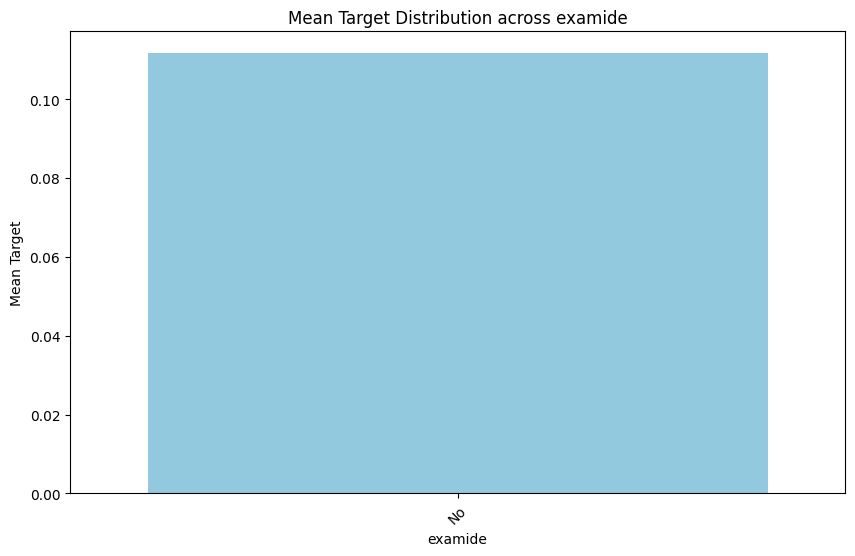

Column: citoglipton
  citoglipton  mean_target
0          No     0.111599


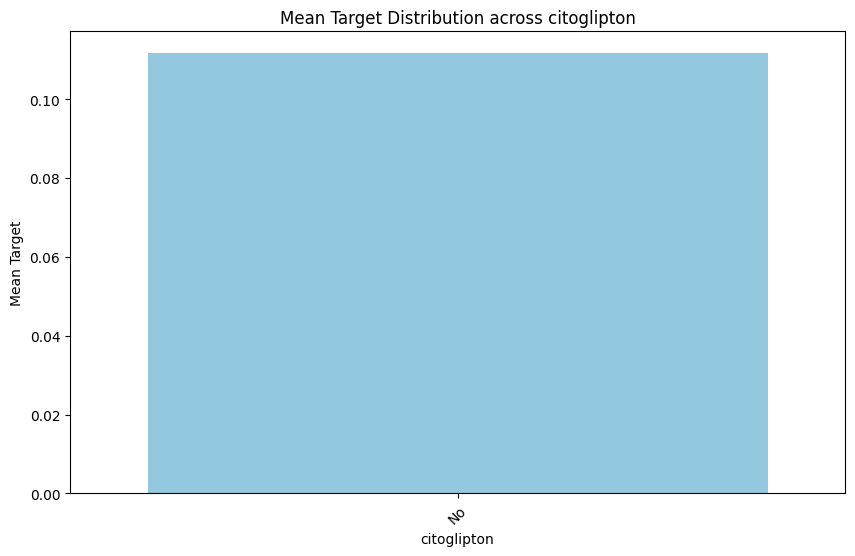

Column: insulin
  insulin  mean_target
0    Down     0.138975
1      No     0.100374
2  Steady     0.111284
3      Up     0.129905


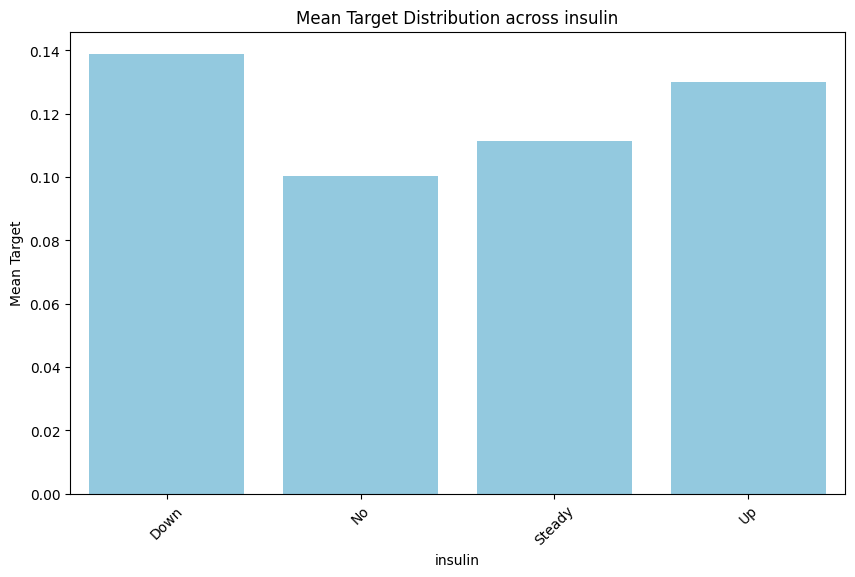

Column: glyburide-metformin
  glyburide-metformin  mean_target
0                Down     0.166667
1                  No     0.111607
2              Steady     0.111272
3                  Up     0.000000


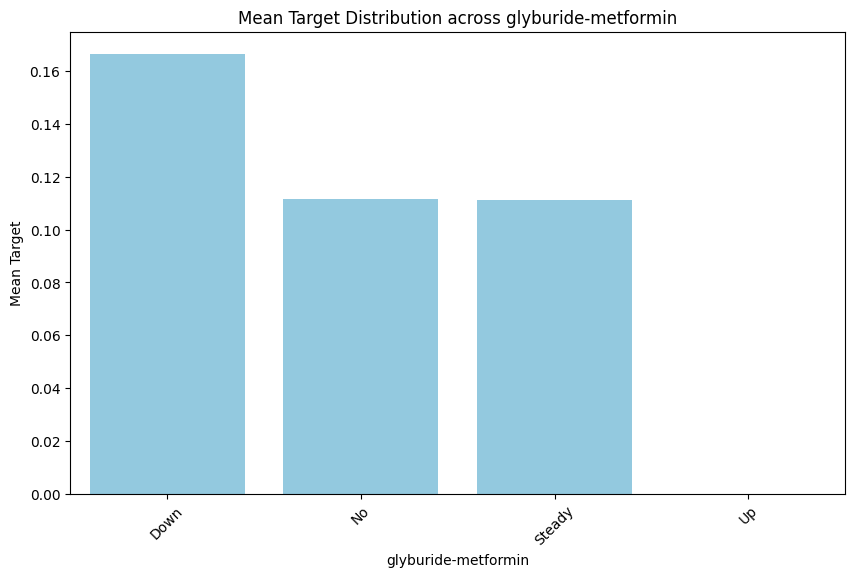

Column: glipizide-metformin
  glipizide-metformin  mean_target
0                  No     0.111604
1              Steady     0.076923


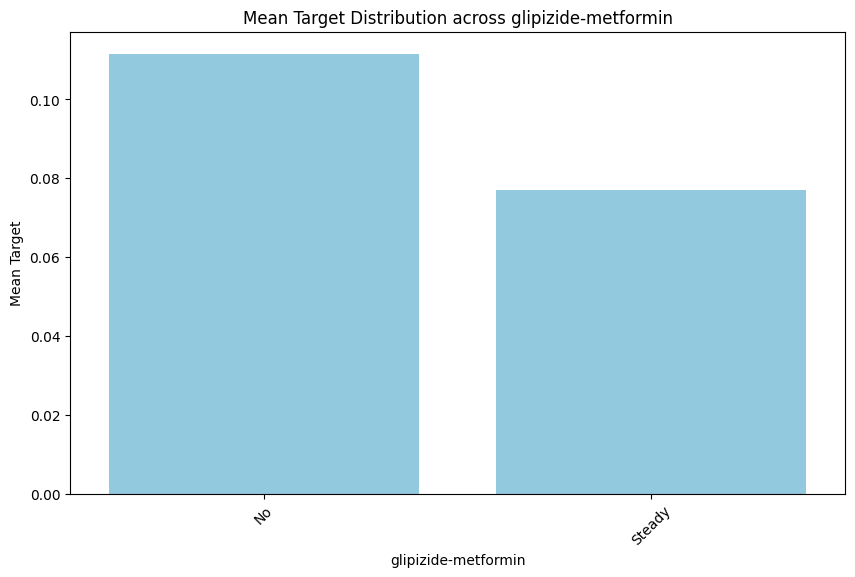

Column: glimepiride-pioglitazone
  glimepiride-pioglitazone  mean_target
0                       No       0.1116
1                   Steady       0.0000


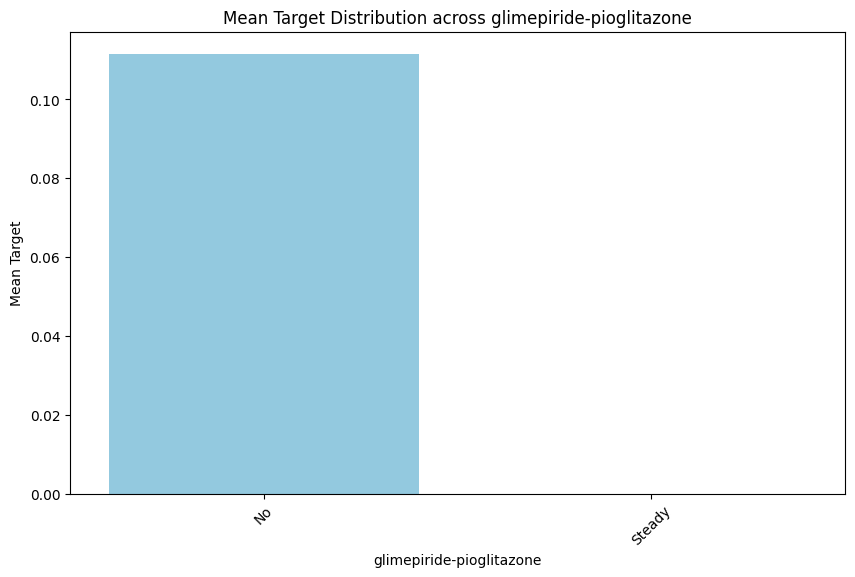

Column: metformin-rosiglitazone
  metformin-rosiglitazone  mean_target
0                      No     0.111601
1                  Steady     0.000000


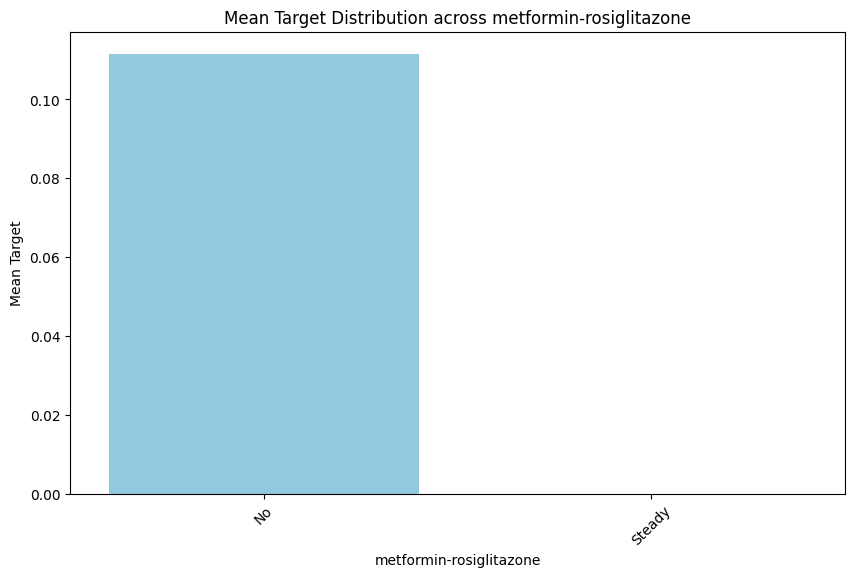

Column: metformin-pioglitazone
  metformin-pioglitazone  mean_target
0                     No       0.1116
1                 Steady       0.0000


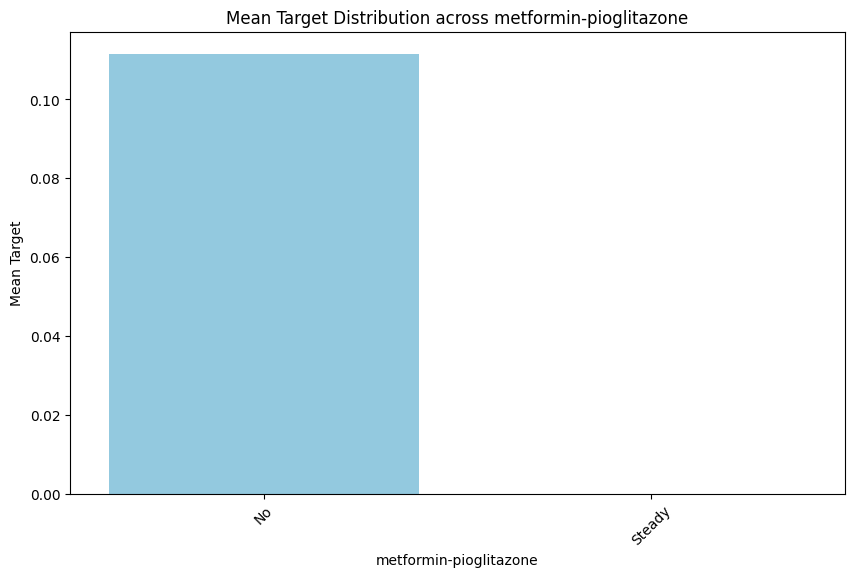

Column: change
  change  mean_target
0     Ch     0.118228
1     No     0.105908


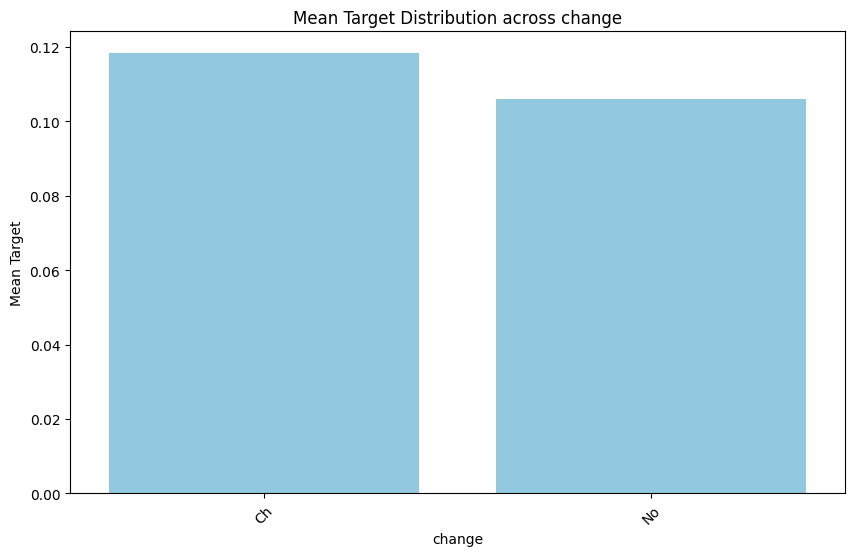

Column: diabetesMed
  diabetesMed  mean_target
0          No     0.095971
1         Yes     0.116267


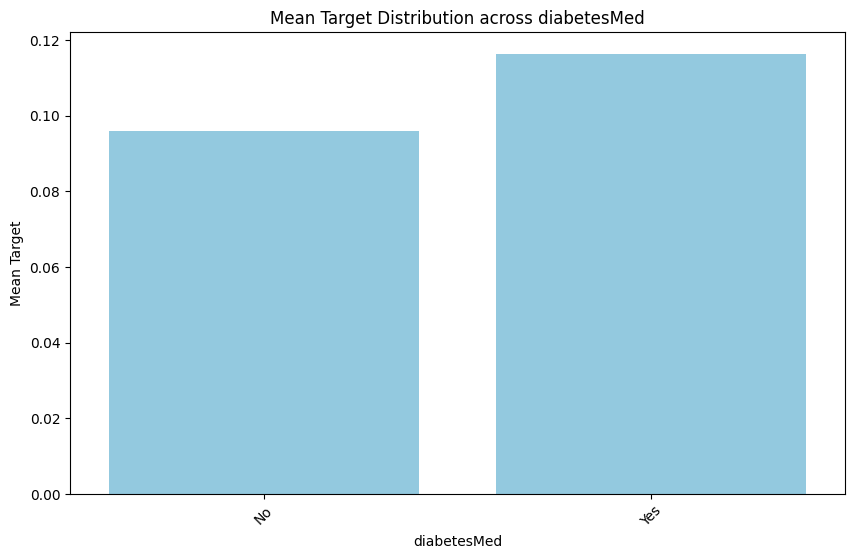

Column: readmitted
  readmitted  mean_target
0        <30          1.0
1        >30          0.0
2         NO          0.0


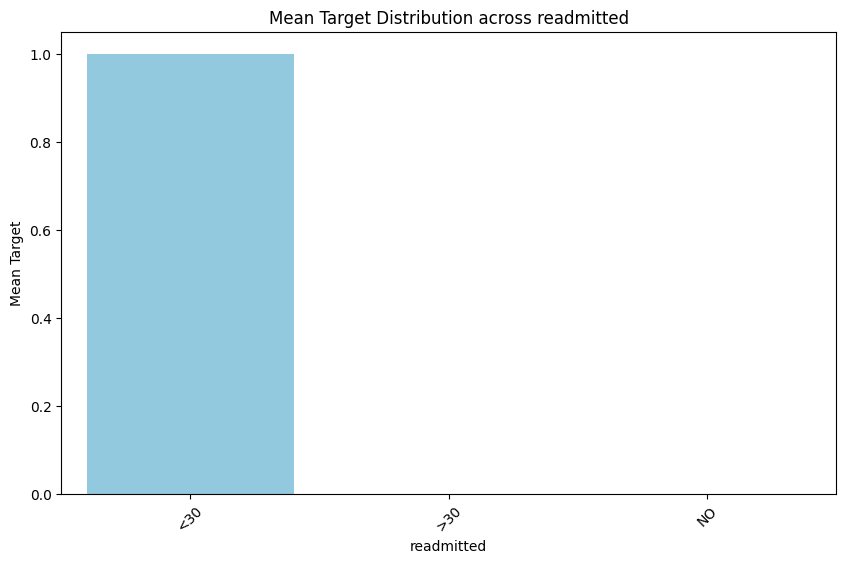

Column: admission_type
  admission_type  mean_target
0       Elective     0.103927
1      Emergency     0.115225
2        Newborn     0.100000
3  Not Available     0.103448
4     Not Mapped     0.084375
5  Trauma Center     0.000000
6         Urgent     0.111797


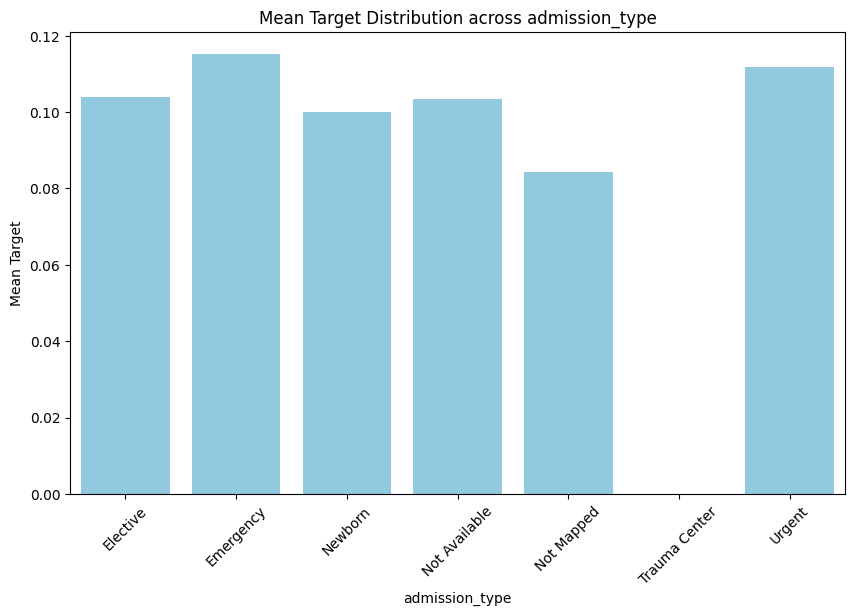

Column: discharge_disposition
                                discharge_disposition  mean_target
0           Admitted as an inpatient to this hospital     0.428571
1                                  Discharged to home     0.093004
2                       Discharged/transferred to ICF     0.127607
3                       Discharged/transferred to SNF     0.146625
4   Discharged/transferred to a federal health car...     0.000000
5   Discharged/transferred to a long term care hos...     0.072816
6   Discharged/transferred to a nursing facility c...     0.145833
7   Discharged/transferred to another rehab fac in...     0.276969
8   Discharged/transferred to another short term h...     0.160714
9   Discharged/transferred to another type of inpa...     0.208615
10  Discharged/transferred to home under care of H...     0.138889
11  Discharged/transferred to home with home healt...     0.126957
12  Discharged/transferred within this institution...     0.444444
13  Discharged/transferred/refer

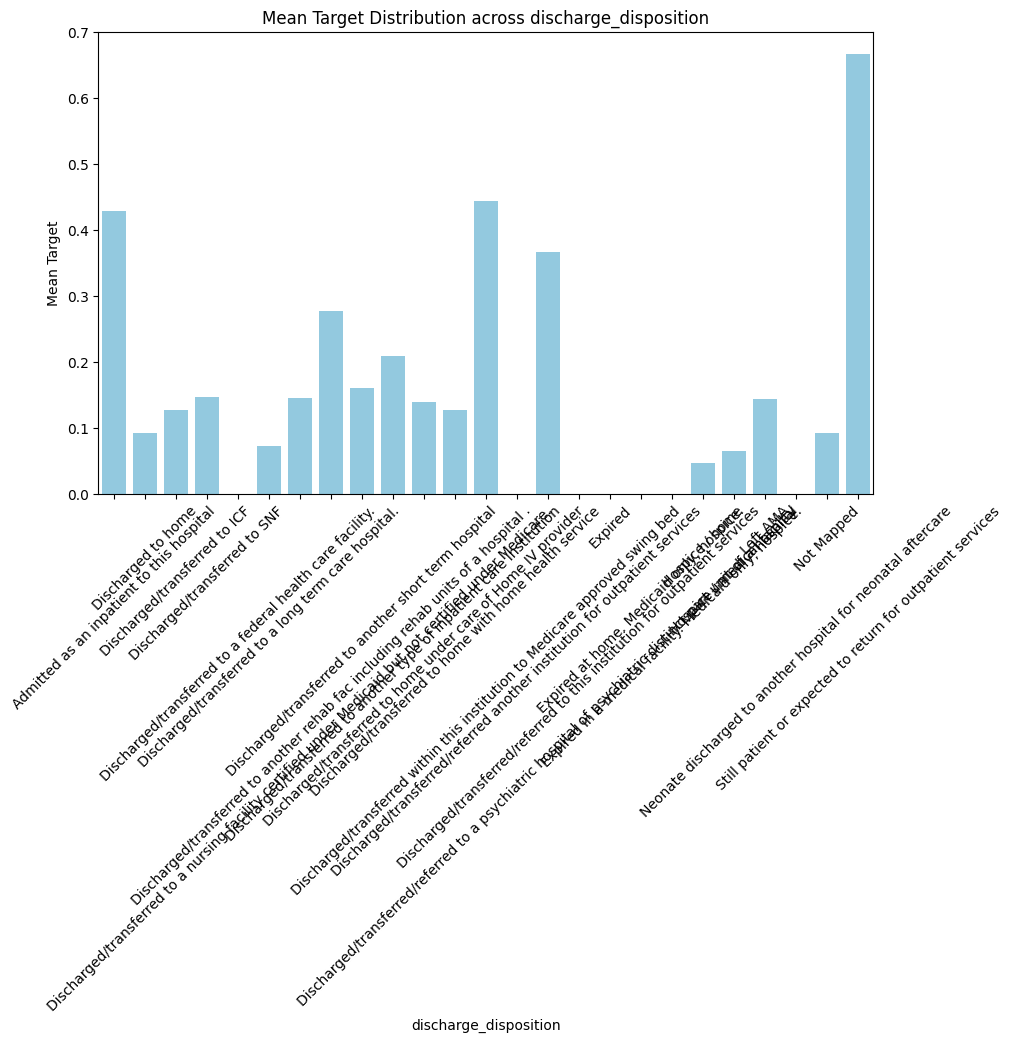

Column: admission_source
                                     admission_source  mean_target
0                               Court/Law Enforcement     0.125000
1                                      Emergency Room     0.116882
2                                    Extramural Birth     0.000000
3                                       Not Available     0.104000
4                                          Not Mapped     0.136646
5                                  Physician Referral     0.105868
6                                           Sick Baby     0.000000
7             Transfer from Ambulatory Surgery Center     0.000000
8      Transfer from a Skilled Nursing Facility (SNF)     0.118129
9          Transfer from another health care facility     0.093640
10              Transfer from critial access hospital     0.000000
11   Transfer from hospital inpt/same fac reslt in...     0.166667
12                                    Clinic Referral     0.100543
13                                   

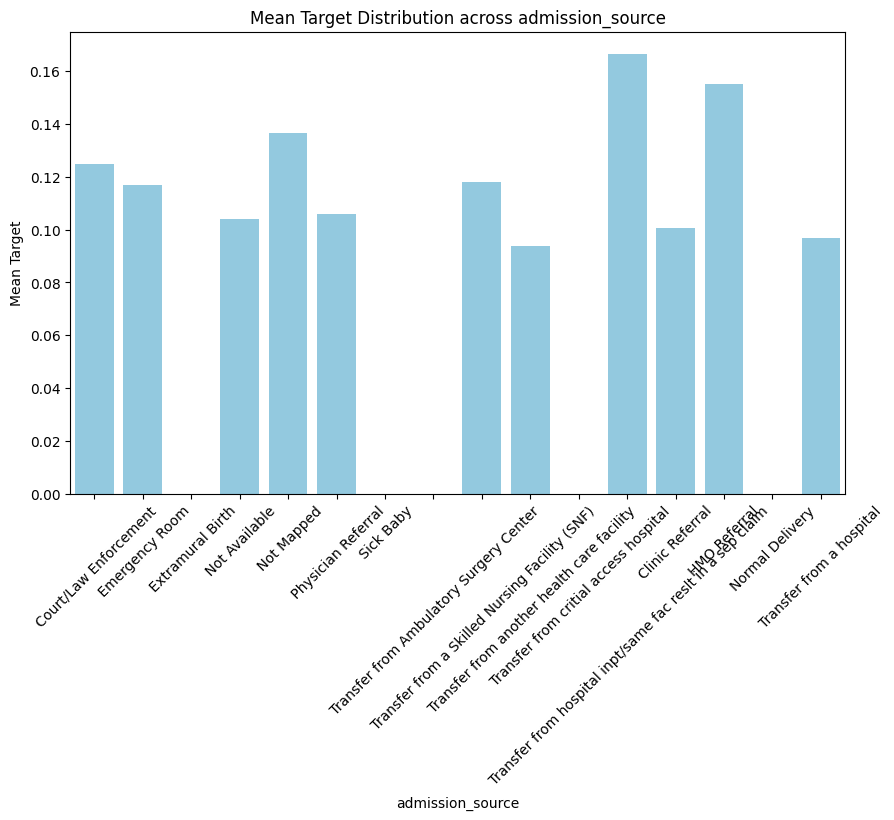

In [11]:
#EDA and distributions of variables wrt response variable
# Convert 'readmitted' column to numeric
df['readmitted_numeric'] = df['readmitted'].map({'>30': 0, '<30': 1, 'NO': 0})

# Iterate through each categorical column
for column in df.columns:
    if df[column].dtype == 'object':  # Check if the column is categorical
        print(f"Column: {column}")
        
        # Group by the categorical column and calculate the mean of the target variable
        target_summary = df.groupby(column)['readmitted_numeric'].mean().reset_index(name='mean_target')
        print(target_summary)
        
        # Visualize the distribution of the target variable across different categories
        plt.figure(figsize=(10, 6))
        sns.barplot(x=column, y='mean_target', data=target_summary, color='skyblue')
        plt.title(f"Mean Target Distribution across {column}")
        plt.xlabel(column)
        plt.ylabel("Mean Target")
        plt.xticks(rotation=45)
        plt.show()
        
        print("=" * 50)  # Separator for readability

# Drop the temporary column 'readmitted_numeric'
df.drop(columns=['readmitted_numeric'], inplace=True)


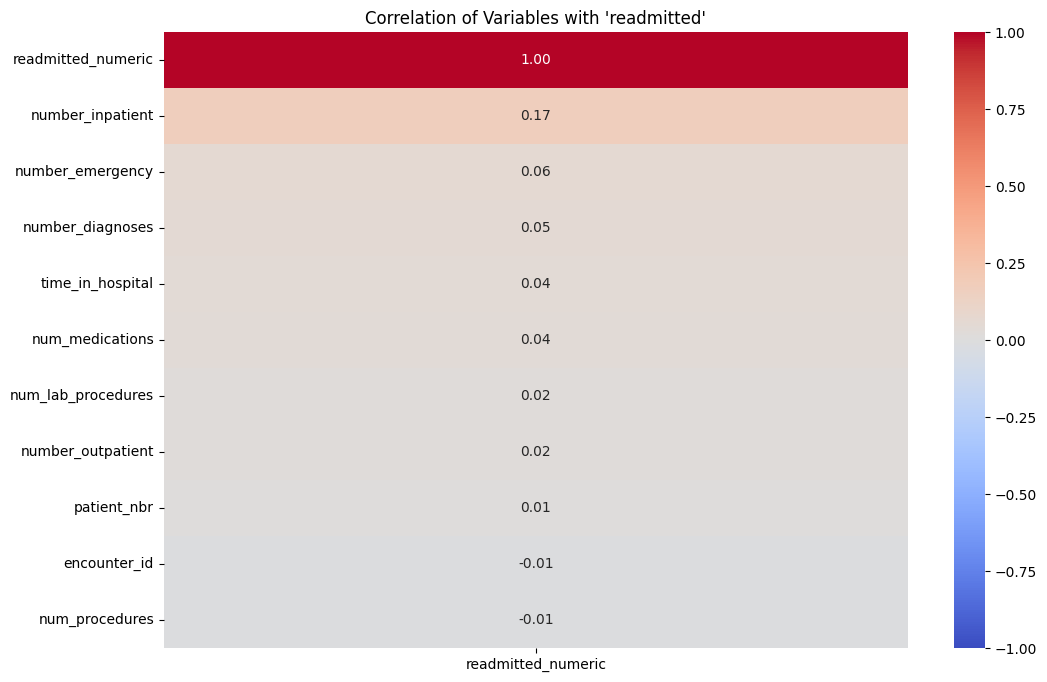

In [12]:
#Checking corelation with response variable
# Encode the 'readmitted' variable into numeric values
readmitted_mapping = {'NO': 0, '>30': 0, '<30': 1}
df['readmitted_numeric'] = df['readmitted'].map(readmitted_mapping)

# Calculate the correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['readmitted_numeric']].sort_values(by='readmitted_numeric', ascending=False),
            cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation of Variables with 'readmitted'")
plt.show()

# Drop the temporary column 'readmitted_numeric'
df.drop(columns=['readmitted_numeric'], inplace=True)


In [13]:
#Data cleaning

# dropping of clumns with more than 90% of null values
df = df.drop(columns=['weight','medical_specialty','payer_code'])
print(len(df.columns))
 
# replacing null values with Unknown for other null value data columns
df['race'] = df['race'].replace('?', 'Unknown')
df['max_glu_serum'] = df['max_glu_serum'].fillna('Unknown')
df['A1Cresult'] = df['A1Cresult'].fillna('Unknown')
df['admission_type'] = df['admission_type'].fillna('Unknown')
df['discharge_disposition'] = df['discharge_disposition'].fillna('Unknown')
df['admission_source'] = df['admission_source'].fillna('Unknown')

47


In [14]:
# size of actual dataframe
df.shape

(101766, 47)

In [15]:
# Dummy Encoding of categorical variables

dummies = pd.get_dummies(df, columns = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin','repaglinide', 'nateglinide','chlorpropamide','glimepiride', 'acetohexamide',
                                              'glipizide', 'glyburide','tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', 'troglitazone',
                                              'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
                                              'metformin-rosiglitazone', 'metformin-pioglitazone', 'change','diabetesMed', 'admission_type', 
                                        'discharge_disposition', 'admission_source'])

dummies['readmitted'] = dummies['readmitted'].replace({'NO': 0, '>30': 0, '<30': 1})
print(len(dummies.columns))

for column in dummies:
        print(column)
 

167
encounter_id
patient_nbr
time_in_hospital
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
diag_1
diag_2
diag_3
number_diagnoses
readmitted
race_AfricanAmerican
race_Asian
race_Caucasian
race_Hispanic
race_Other
race_Unknown
gender_Female
gender_Male
gender_Unknown/Invalid
age_[0-10)
age_[10-20)
age_[20-30)
age_[30-40)
age_[40-50)
age_[50-60)
age_[60-70)
age_[70-80)
age_[80-90)
age_[90-100)
max_glu_serum_>200
max_glu_serum_>300
max_glu_serum_Norm
max_glu_serum_Unknown
A1Cresult_>7
A1Cresult_>8
A1Cresult_Norm
A1Cresult_Unknown
metformin_Down
metformin_No
metformin_Steady
metformin_Up
repaglinide_Down
repaglinide_No
repaglinide_Steady
repaglinide_Up
nateglinide_Down
nateglinide_No
nateglinide_Steady
nateglinide_Up
chlorpropamide_Down
chlorpropamide_No
chlorpropamide_Steady
chlorpropamide_Up
glimepiride_Down
glimepiride_No
glimepiride_Steady
glimepiride_Up
acetohexamide_No
acetohexamide_Steady
glipizide_Down
glipizide_No
glipizide_S

In [16]:
# dropping of less significant columns and preparing final dataframe
final_hospi = dummies.drop(['encounter_id', 'patient_nbr', 'diag_1', 'diag_2', 'diag_3'], axis = 'columns')
final_hospi

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,race_AfricanAmerican,...,admission_source_ Transfer from Ambulatory Surgery Center,admission_source_ Transfer from a Skilled Nursing Facility (SNF),admission_source_ Transfer from another health care facility,admission_source_ Transfer from critial access hospital,admission_source_ Transfer from hospital inpt/same fac reslt in a sep claim,admission_source_Clinic Referral,admission_source_HMO Referral,admission_source_Normal Delivery,admission_source_Transfer from a hospital,admission_source_Unknown
0,1,41,0,1,0,0,0,1,0,False,...,False,False,False,False,False,False,False,False,False,False
1,3,59,0,18,0,0,0,9,0,False,...,False,False,False,False,False,False,False,False,False,False
2,2,11,5,13,2,0,1,6,0,True,...,False,False,False,False,False,False,False,False,False,False
3,2,44,1,16,0,0,0,7,0,False,...,False,False,False,False,False,False,False,False,False,False
4,1,51,0,8,0,0,0,5,0,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,3,51,0,16,0,0,0,9,0,True,...,False,False,False,False,False,False,False,False,False,False
101762,5,33,3,18,0,0,1,9,0,True,...,False,True,False,False,False,False,False,False,False,False
101763,1,53,0,9,1,0,0,13,0,False,...,False,False,False,False,False,False,False,False,False,False
101764,10,45,2,21,0,0,1,9,0,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
# Viewing of all columns in final dataframe
for column in final_hospi.columns:
    print(column)

time_in_hospital
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
number_diagnoses
readmitted
race_AfricanAmerican
race_Asian
race_Caucasian
race_Hispanic
race_Other
race_Unknown
gender_Female
gender_Male
gender_Unknown/Invalid
age_[0-10)
age_[10-20)
age_[20-30)
age_[30-40)
age_[40-50)
age_[50-60)
age_[60-70)
age_[70-80)
age_[80-90)
age_[90-100)
max_glu_serum_>200
max_glu_serum_>300
max_glu_serum_Norm
max_glu_serum_Unknown
A1Cresult_>7
A1Cresult_>8
A1Cresult_Norm
A1Cresult_Unknown
metformin_Down
metformin_No
metformin_Steady
metformin_Up
repaglinide_Down
repaglinide_No
repaglinide_Steady
repaglinide_Up
nateglinide_Down
nateglinide_No
nateglinide_Steady
nateglinide_Up
chlorpropamide_Down
chlorpropamide_No
chlorpropamide_Steady
chlorpropamide_Up
glimepiride_Down
glimepiride_No
glimepiride_Steady
glimepiride_Up
acetohexamide_No
acetohexamide_Steady
glipizide_Down
glipizide_No
glipizide_Steady
glipizide_Up
glyburide_Down
glyburide_No
gly

In [18]:
#shape of final dataframe
final_hospi.shape

(101766, 162)

In [ ]:
# Dropping variables highly correlated with each other
# Calculate the correlation matrix
correlation_matrix = final_hospi.corr().abs()

# Exclude diagonal elements from consideration
np.fill_diagonal(correlation_matrix.values, np.nan)

# Find index of feature columns with correlation greater than 0.8
to_drop_corr_with_each_other = [column for column in correlation_matrix.columns if any(correlation_matrix[column] > 0.8)]

# Drop the highly correlated features
final_hospi_no_collinear = final_hospi.drop(columns=to_drop_corr_with_each_other, errors='ignore')  # Use errors='ignore' to handle cases where 'readmitted' column might have been dropped

print("Variables dropped due to high correlation with each other:")
print(to_drop_corr_with_each_other)

# Check if 'readmitted' column exists in the dataframe
if 'readmitted' in final_hospi_no_collinear.columns:
    # Drop variables highly correlated with the target variable ('readmitted')
    # Calculate the correlation matrix with the target variable
    correlation_with_target = final_hospi_no_collinear.corrwith(final_hospi_no_collinear['readmitted']).abs().sort_values(ascending=False)

    # Select variables highly correlated with the target variable
    to_drop_corr_with_target = correlation_with_target[correlation_with_target > 0.5].index.tolist()

    # Drop the highly correlated features with the target variable
    final_hospi_no_collinear = final_hospi_no_collinear.drop(columns=to_drop_corr_with_target, errors='ignore')  # Use errors='ignore' to handle cases where 'readmitted' column might have been dropped

    print("Variables dropped due to high correlation with the target variable ('readmitted'):")
    print(to_drop_corr_with_target)
else:
    print("No 'readmitted' column found. Skipping correlation with the target variable.")

# Rename final_hospi_no_collinear to final_hospi and ensure 'readmitted' column is present
final_hospi = final_hospi_no_collinear.copy()

print("Final dataframe shape after dropping highly correlated features:")
print(final_hospi.shape)

In [ ]:
final_hospi['readmitted'] = df['readmitted'].map({'<30': 1, '>30': 0, 'NO': 0})

In [ ]:
# Dividing the final data frame into predictor and response variables and further train test split

Y = final_hospi['readmitted']
X = final_hospi.drop(['readmitted'], axis=1, inplace = False)
# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Y_train = pd.DataFrame(data=Y_train.values, columns=['readmitted'])
Y_test = pd.DataFrame(data=Y_test.values, columns=['readmitted'])

# Y_train = Y_train.ravel()
# Y_test = Y_test.ravel()

# Printing the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

In [ ]:
# Applying SMOTE for balancing of all the classes 

smote = SMOTE(random_state=42)
X_res, Y_res = smote.fit_resample(X_train, Y_train)
 
# After SMOTE
print("After SMOTE:")
print(Y_res.value_counts())
 
#  X_res and Y_res are the balanced training dataset obtained after applying SMOTE
# Silimar for X_test and Y_test are the test dataset


In [ ]:
# MODEL1: LOGISTIC REGRESSION 
# Scale the input features
scaler = StandardScaler()
 # Using X_res after SMOTE for training
X_train_scaled = scaler.fit_transform(X_res) 
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression with scaled data and increased max_iter
logreg = LogisticRegression(max_iter=1000)  # Increase max_iter
logreg.fit(X_train_scaled, Y_res)  # Using Y_res after SMOTE for training

# Evaluate the model on the test data
logreg_preds = logreg.predict(X_test_scaled)

# Perform k-fold cross-validation
cv_scores_logreg = cross_val_score(logreg, X_train_scaled, Y_res, cv=5, scoring='accuracy')
print("Cross-Validation Scores (Logistic Regression):", cv_scores_logreg)
print("Mean CV Accuracy (Logistic Regression):", np.mean(cv_scores_logreg))

In [ ]:
# Scale the input features
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)

# Train the logistic regression model
logreg_rfe = LogisticRegression(multi_class='auto', max_iter=1000)

# logreg_rfe = LogisticRegression()
logreg_rfe.fit(X_res_scaled, Y_res)

# Evaluate the model using cross-validation
logreg_preds_cv = cross_val_predict(logreg_rfe, X_res_scaled, Y_res, cv=5)
cv_scores = cross_val_score(logreg_rfe, X_res_scaled, Y_res, cv=5, scoring='accuracy')
mean_cv_accuracy = cv_scores.mean()

print("Mean CV Accuracy (Logistic Regression):", mean_cv_accuracy)

In [ ]:

# Calculate performance metrics for weighted average
accuracy_wl_cv = accuracy_score(Y_res, logreg_preds_cv)
precision_wl_cv = precision_score(Y_res, logreg_preds_cv, average='weighted')  
recall_wl_cv = recall_score(Y_res, logreg_preds_cv, average='weighted')  
f1_wl_cv = f1_score(Y_res, logreg_preds_cv, average='weighted')  
  

# Print summary metrics
print("Summary Metrics of Logistic Regression Weighted average (CV):")
print(f"Accuracy: {accuracy_wl_cv:.2f}")
print(f"Precision: {precision_wl_cv:.2f}")
print(f"Recall: {recall_wl_cv:.2f}")
print(f"F1 Score: {f1_wl_cv:.2f}")


In [ ]:
# Prediction on Logistic Model


# Predict on the test data
X_test_scaled = scaler.transform(X_test)  # Scale the test data using the same scaler
Y_pred_test = logreg_rfe.predict(X_test_scaled)

# Evaluate the model on the test data
test_accuracy = accuracy_score(Y_test, Y_pred_test)
print("Test Accuracy (Logistic Regression):", test_accuracy)

In [ ]:
# Prediction Scores on Logistic Model


# Compute accuracy
test_accuracy = accuracy_score(Y_test, Y_pred_test)

# Compute precision
test_precision = precision_score(Y_test, Y_pred_test, average='weighted')

# Compute recall
test_recall = recall_score(Y_test, Y_pred_test, average='weighted')

# Compute F1-score
test_f1 = f1_score(Y_test, Y_pred_test, average='weighted')

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_test)

print("Test Accuracy: {:.2f}".format(test_accuracy))
print("Test Precision: {:.2f}".format(test_precision))
print("Test Recall: {:.2f}".format(test_recall))
print("Test F1-score: {:.2f}".format(test_f1))
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
# confusion matrix
def display_binary_confusion_matrix(conf_matrix):
    """
    Display binary confusion matrix.
    
    Parameters:
        conf_matrix (numpy.ndarray): Binary confusion matrix.
    """
    # Convert confusion matrix to numpy array
    conf_matrix = np.array(conf_matrix)
    
    # Print header row
    header_row = " " * 12  # Space for alignment
    header_row += f"{'Predicted:':^10}"
    header_row += "\n"
    header_row += " " * 12
    header_row += f"{'Negative':^10}{'Positive':^10}"
    print(header_row)
    
    # Print rows of confusion matrix
    row_strings = [f"{'Actual:':<10}"]
    for i in range(2):
        row_string = f"{' '*10}{conf_matrix[i, 0]:^10}{conf_matrix[i, 1]:^10}"
        row_strings.append(row_string)
    print("\n".join(row_strings))

# Example usage for binary confusion matrix
binary_conf_matrix = [[18025, 44],
                      [2250, 35]]

print("Binary Confusion Matrix:")
display_binary_confusion_matrix(binary_conf_matrix)


Binary Confusion Matrix:


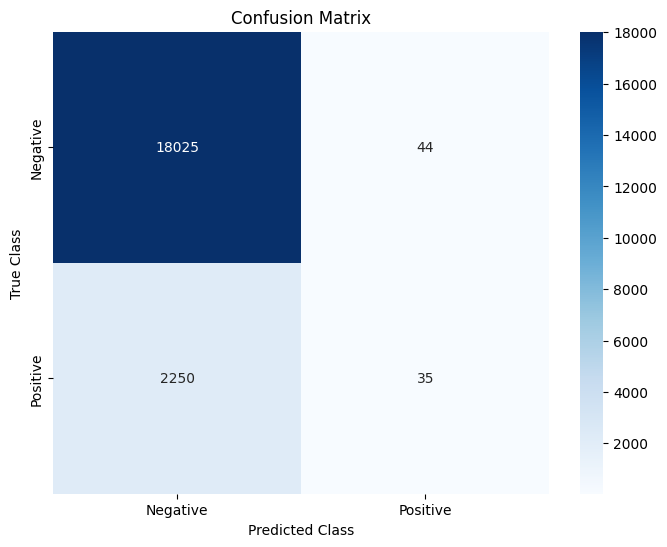

In [36]:
# Visulaizing of confusion matrix of logistic model

def display_binary_confusion_matrix(conf_matrix):
    """
    Display binary confusion matrix.
    
    Parameters:
        conf_matrix (numpy.ndarray): Binary confusion matrix.
    """
    # Convert confusion matrix to numpy array
    conf_matrix = np.array(conf_matrix)
    
    # Define class labels for better interpretation
    classes = ['Negative', 'Positive']
    
    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage for binary confusion matrix
binary_conf_matrix = [[18025, 44],
                      [2250, 35]]

print("Binary Confusion Matrix:")
display_binary_confusion_matrix(binary_conf_matrix)


In [37]:
# Get the parameters of the logistic regression model
# this is to cross check if multiclass is not enabled for response variable
logreg_params = logreg_rfe.get_params()

# Check the relevant parameters for binary classification
print("multi_class parameter:", logreg_params['multi_class'])
print("solver parameter:", logreg_params['solver'])

multi_class parameter: auto
solver parameter: lbfgs


In [38]:
# ROC AUC score for Logistic model


# Predict probabilities for the positive class
Y_pred_prob = logreg_rfe.predict_proba(X_test_scaled)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

print("ROC AUC (Logistic Regression): {:.2f}".format(roc_auc))


ROC AUC (Logistic Regression): 0.66


In [39]:
# MODEL2: RANDOM FOREST CLASSIFIER
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, Y_train)

# Evaluate the model on the validation set
Y_pred_val = rf_model.predict(X_val)
print("Validation Performance (Random Forest):")
print(classification_report(Y_val, Y_pred_val))

Validation Performance (Random Forest):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.41      0.01      0.02      2285

    accuracy                           0.89     20354
   macro avg       0.65      0.50      0.48     20354
weighted avg       0.83      0.89      0.84     20354



In [41]:
# predicting matrics

accuracy_wr = accuracy_score(Y_val, Y_pred_val)
precision_wr = precision_score(Y_val, Y_pred_val, average='weighted')
recall_wr = recall_score(Y_val, Y_pred_val, average='weighted')
f1_wr = f1_score(Y_val, Y_pred_val, average='weighted')


# Print metrics
print("Validation Performance (Random Forest) Weighted Average:")
print(f"Accuracy: {accuracy_wr:.2f}")
print(f"Precision: {precision_wr:.2f}")
print(f"Recall: {recall_wr:.2f}")
print(f"F1 Score: {f1_wr:.2f}")


# Macro average gives each prediction similar weight while calculating loss but 
# there might be case when your data might be imbalanced and you want to give importance to 
# some prediction more (based on their proportion), there you use 'weighted' average.

Validation Performance (Random Forest) Weighted Average:
Accuracy: 0.89
Precision: 0.83
Recall: 0.89
F1 Score: 0.84


In [42]:
# Make predictions on the test data using the trained random forest classifier
Y_pred_test_rf = rf_model.predict(X_test)

# Calculate performance metrics for the random forest classifier on the test data
accuracy_rf_test = accuracy_score(Y_test, Y_pred_test_rf)
precision_rf_test = precision_score(Y_test, Y_pred_test_rf, average='weighted')
recall_rf_test = recall_score(Y_test, Y_pred_test_rf, average='weighted')
f1_rf_test = f1_score(Y_test, Y_pred_test_rf, average='weighted')

# Print the performance metrics for the random forest classifier on the test data
print("Random Forest Classifier Performance on Test Data:")
print(f"Accuracy: {accuracy_rf_test:.2f}")
print(f"Precision: {precision_rf_test:.2f}")
print(f"Recall: {recall_rf_test:.2f}")
print(f"F1 Score: {f1_rf_test:.2f}")


Random Forest Classifier Performance on Test Data:
Accuracy: 0.89
Precision: 0.83
Recall: 0.89
F1 Score: 0.84


In [43]:
# prediction metrics and AUC for random forest classifer

# Convert Y_test to array if it's not already in the correct format
Y_test = Y_test.values.ravel() if isinstance(Y_test, pd.DataFrame) else Y_test

# Convert the target labels to numerical format
label_encoder = LabelEncoder()
Y_test_encoded = label_encoder.fit_transform(Y_test)

# Flatten the encoded array to ensure it is 1-dimensional
Y_test_encoded = Y_test_encoded.ravel()

# Predict probabilities for each class
Y_prob_test = rf_model.predict_proba(X_test)

# Calculate AUC score
auc_score = roc_auc_score(Y_test_encoded, Y_prob_test[:, 1])  # Assuming binary classification

print("AUC Score on Test Data (Random Forest):", auc_score)


AUC Score on Test Data (Random Forest): 0.6401058766583192


After selection of AUC scores we test performace of each model with top selected features

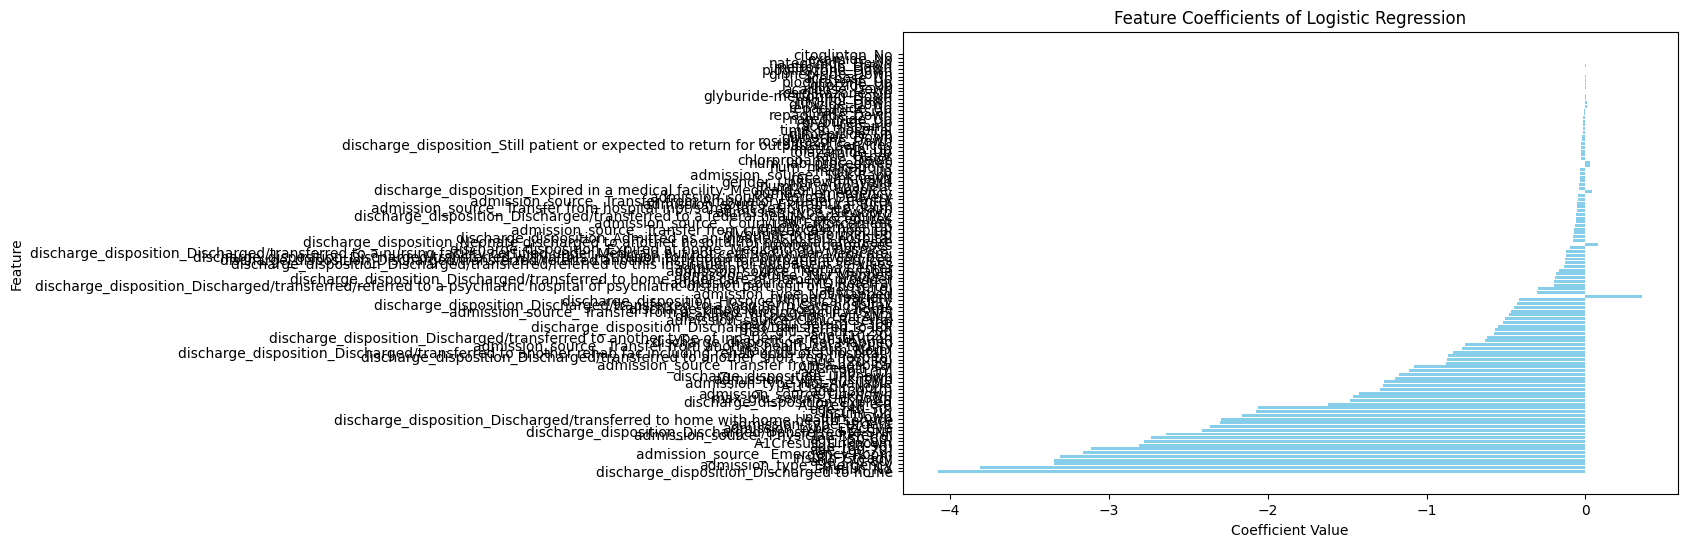

In [44]:
# Get feature coefficients from the logistic regression model
coefficients = logreg_rfe.coef_[0]

# Get feature names
feature_names = X_train.columns

# Create a DataFrame to store feature coefficients
feature_coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort features by absolute coefficient values
feature_coef_df['Abs_Coefficient'] = feature_coef_df['Coefficient'].abs()
feature_coef_df = feature_coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Plot feature coefficients
plt.figure(figsize=(10, 6))
plt.barh(feature_coef_df['Feature'], feature_coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Coefficients of Logistic Regression')
plt.show()


In [45]:
# Get top 10 features based on absolute coefficient values
top_features_lr = feature_coef_df['Feature'][:10].tolist()
print("Top 10 Features for Logistic Regression:")
print(top_features_lr)

Top 10 Features for Logistic Regression:
['discharge_disposition_Discharged to home', 'insulin_No', 'admission_type_Emergency', 'age_[70-80)', 'insulin_Steady', 'admission_source_ Emergency Room', 'age_[60-70)', 'age_[80-90)', 'A1Cresult_Unknown', 'age_[50-60)']


In [46]:
# Train logistic regression model using all features
logreg_all_features = LogisticRegression()
logreg_all_features.fit(X_train, Y_train)

# Predictions on test data using logistic regression with all features
logreg_all_features_preds = logreg_all_features.predict(X_test)

# Calculate accuracy using all features
logreg_all_features_accuracy = accuracy_score(Y_test, logreg_all_features_preds)

# Train logistic regression model using only top 10 features
logreg_selected_features = LogisticRegression()
logreg_selected_features.fit(X_train[top_features_lr], Y_train)

# Predictions on test data using logistic regression with selected features
logreg_selected_features_preds = logreg_selected_features.predict(X_test[top_features_lr])

# Calculate accuracy using selected features
logreg_selected_features_accuracy = accuracy_score(Y_test, logreg_selected_features_preds)

# Compare performance metrics
print("Performance Metrics - Logistic Regression:")
print("All Features Accuracy:", logreg_all_features_accuracy)
print("Selected Features Accuracy:", logreg_selected_features_accuracy)


Performance Metrics - Logistic Regression:
All Features Accuracy: 0.8873440110052078
Selected Features Accuracy: 0.887737054141692


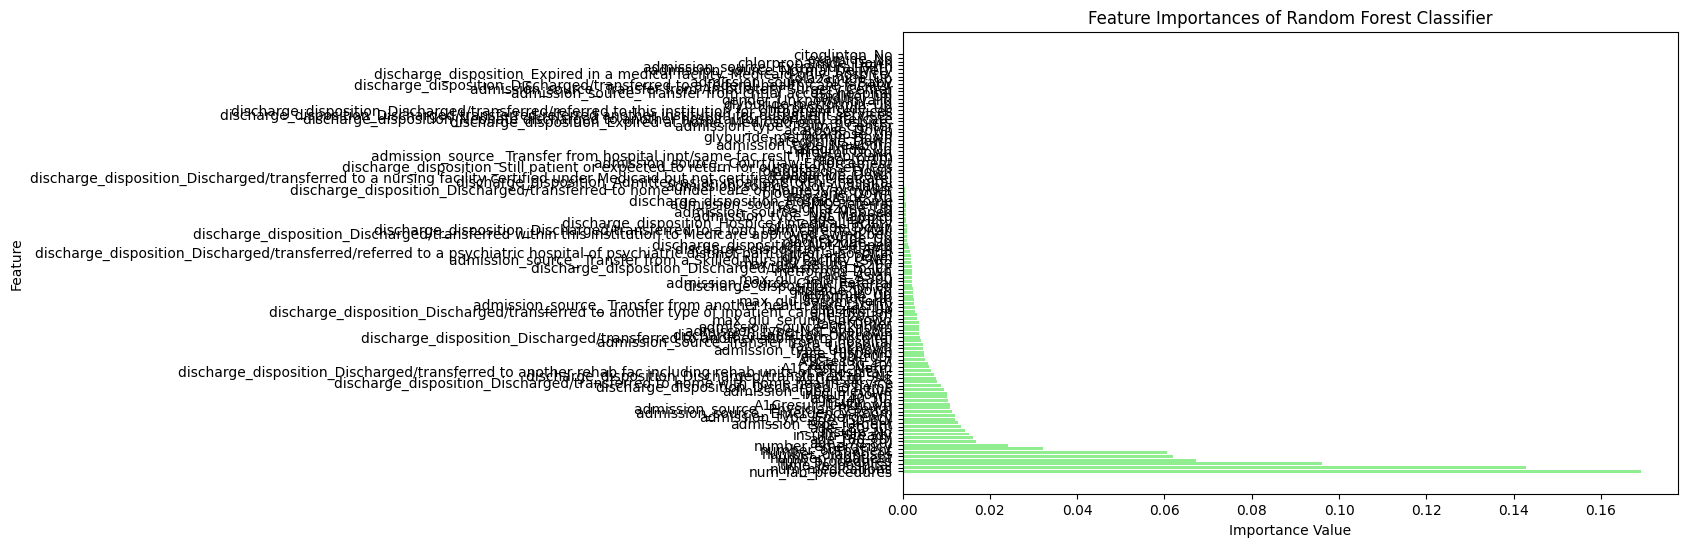

In [47]:
# Get feature importances from the random forest model
importances = rf_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='lightgreen')
plt.xlabel('Importance Value')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Classifier')
plt.show()


In [48]:
# Get top 10 features based on importance values
top_features_rf = feature_importance_df['Feature'][:10].tolist()
print("Top 10 Features for Random Forest Classifier:")
print(top_features_rf)

Top 10 Features for Random Forest Classifier:
['num_lab_procedures', 'num_medications', 'time_in_hospital', 'num_procedures', 'number_inpatient', 'number_diagnoses', 'number_outpatient', 'number_emergency', 'age_[70-80)', 'age_[60-70)']


In [49]:
# Train random forest model using all features
rf_all_features = RandomForestClassifier()
rf_all_features.fit(X_train, Y_train)

# Predictions on test data using random forest with all features
rf_all_features_preds = rf_all_features.predict(X_test)

# Calculate accuracy using all features
rf_all_features_accuracy = accuracy_score(Y_test, rf_all_features_preds)

# Train random forest model using only top 10 features
rf_selected_features = RandomForestClassifier()
rf_selected_features.fit(X_train[top_features_rf], Y_train)

# Predictions on test data using random forest with selected features
rf_selected_features_preds = rf_selected_features.predict(X_test[top_features_rf])

# Calculate accuracy using selected features
rf_selected_features_accuracy = accuracy_score(Y_test, rf_selected_features_preds)

# Compare performance metrics
print("Performance Metrics - Random Forest:")
print("All Features Accuracy:", rf_all_features_accuracy)
print("Selected Features Accuracy:", rf_selected_features_accuracy)


Performance Metrics - Random Forest:
All Features Accuracy: 0.8868527070846025
Selected Features Accuracy: 0.8793357570993416
